<a href="https://colab.research.google.com/github/cohitai/AI_notebooks/blob/main/VAE/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational AutoEncoder = (encoder= Recognition model, decoder=Generative model)+ Variational loss.

 Variational loss = ELBO (evidence lower bound).



In [1]:
#ToDO: visualizations of the latent space, KL divergence explanations, Generative data. 
### Go over these: 
# Not sure I have the "right" variational loss. 
# https://avandekleut.github.io/vae/
# https://www.jeremyjordan.me/variational-autoencoders/
# https://gaussian37.github.io/deep-learning-chollet-8-4/
# simplify NN ? (How many ResNet layers/Blocks? are actiually meaningfull for a baseline.)
# output doesn't converge well. (check loss ? epochs adjustments/learning rate?)
# plot the loss
# change reconstruction loss to recons_loss =F.mse_loss(recons, input).

# The loss depends heavily on the BS. 
# Compare the loss with the pretrained VAE model(Huggingfaces). 
# sum() or mean() in loss , and kl.sum() or kl.mean() ? 


In [2]:
import torch 
import torchvision
from torch import nn
import torch.nn.functional as F
import numpy as np
import os
import math

print("Working directory:", os.getcwd())
device="cuda"

Working directory: /content


In [3]:
!nvidia-smi

Tue Nov 15 12:14:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
## download cifar10 data

In [5]:
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

In [5]:
# !ls

cifar-10-python.tar.gz	sample_data


In [6]:
# !tar -xvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
# !ls -al cifar-10-batches-py

total 181884
drwxr-xr-x 2 2156 1103     4096 Jun  4  2009 .
drwxr-xr-x 1 root root     4096 Nov 14 11:42 ..
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [12]:
# import os.path as osp
# path = "./cifar-10-batches-py"
# def unpickle(file):
#     import pickle
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo, encoding='bytes')
#     return dict

# !ls $path

# c10_data = unpickle(osp.join(path,"data_batch_1"))
# print(c10_data.keys())

# # extract c10 data --> images,labels
# images = c10_data[b"data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") # (10000,3072)
# labels = c10_data[b"labels"]
# #
# print("Data Shape",images.shape)

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data Shape (10000, 32, 32, 3)


Model Blocks: - DownEncoderBlock2D
              - UpDecoderBlock2D
              - ResnetBlock
              - Downsample2D
              - Upsample2D
              - AttentionBlockNew
              - UNetMidBlock2D
              - Encoder
              - Decoder

In [6]:
class DownEncoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0, 
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_downsample=True,
        downsample_padding=1,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        in_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        else:
            self.downsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

        return hidden_states

class UpDecoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_upsample=True,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            input_channels = in_channels if i == 0 else out_channels

            resnets.append(
                ResnetBlock(
                    in_channels=input_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        else:
            self.upsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states)

        return hidden_states

  
    
class ResnetBlock(nn.Module):
    def __init__(
        self,
        *,
        in_channels,
        out_channels=None,
        conv_shortcut=False,
        dropout=0.0,
        temb_channels=512,
        groups=32,
        groups_out=None,
        pre_norm=True,
        eps=1e-6,
        non_linearity="swish",
        time_embedding_norm="default",
        kernel=None,
        output_scale_factor=1.0,
        use_nin_shortcut=None,
        up=False,
        down=False,
    ):
        super().__init__()
        self.pre_norm = pre_norm
        self.pre_norm = True
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut
        self.time_embedding_norm = time_embedding_norm
        self.up = up
        self.down = down
        self.output_scale_factor = output_scale_factor

        if groups_out is None:
            groups_out = groups

        self.norm1 = torch.nn.GroupNorm(num_groups=groups, num_channels=in_channels, eps=eps, affine=True)

        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if temb_channels is not None:
            self.time_emb_proj = torch.nn.Linear(temb_channels, out_channels)
        else:
            self.time_emb_proj = None

        self.norm2 = torch.nn.GroupNorm(num_groups=groups_out, num_channels=out_channels, eps=eps, affine=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if non_linearity == "swish":
            self.nonlinearity = lambda x: F.silu(x)
        elif non_linearity == "mish":
            self.nonlinearity = Mish()
        elif non_linearity == "silu":
            self.nonlinearity = nn.SiLU()

        self.upsample = self.downsample = None
        if self.up:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.upsample = lambda x: upsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.upsample = partial(F.interpolate, scale_factor=2.0, mode="nearest")
            else:
                self.upsample = Upsample2D(in_channels, use_conv=False)
        
        elif self.down:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.downsample = lambda x: downsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.downsample = partial(F.avg_pool2d, kernel_size=2, stride=2)
            else:
                self.downsample = Downsample2D(in_channels, use_conv=False, padding=1, name="op")

        self.use_nin_shortcut = self.in_channels != self.out_channels if use_nin_shortcut is None else use_nin_shortcut

        self.conv_shortcut = None
    
        if self.use_nin_shortcut:
            self.conv_shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, temb, hey=False):
        h = x

        # print("LOG resnet_input",h.size())

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm1(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        # if self.upsample is not None:
        #     x = self.upsample(x)
        #     h = self.upsample(h)
        # elif self.downsample is not None:
        #     x = self.downsample(x)
        #     h = self.downsample(h)

        h = self.conv1(h)

        # print("LOG temb:",temb is None)

        # if temb is not None:
        #     temb = self.time_emb_proj(self.nonlinearity(temb))[:, :, None, None]
        #     h = h + temb

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm2(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        h = self.dropout(h)
        h = self.conv2(h)

        if self.conv_shortcut is not None:
            x = self.conv_shortcut(x)

        out = (x + h) / self.output_scale_factor

        return out

    def set_weight(self, resnet):
        self.norm1.weight.data = resnet.norm1.weight.data
        self.norm1.bias.data = resnet.norm1.bias.data

        self.conv1.weight.data = resnet.conv1.weight.data
        self.conv1.bias.data = resnet.conv1.bias.data

        if self.time_emb_proj is not None:
            self.time_emb_proj.weight.data = resnet.temb_proj.weight.data
            self.time_emb_proj.bias.data = resnet.temb_proj.bias.data

        self.norm2.weight.data = resnet.norm2.weight.data
        self.norm2.bias.data = resnet.norm2.bias.data

        self.conv2.weight.data = resnet.conv2.weight.data
        self.conv2.bias.data = resnet.conv2.bias.data

        if self.use_nin_shortcut:
            self.conv_shortcut.weight.data = resnet.nin_shortcut.weight.data
            self.conv_shortcut.bias.data = resnet.nin_shortcut.bias.data
            
            
class Downsample2D(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, out_channels=None, padding=1, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.padding = padding
        stride = 2
        self.name = name

        if use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, stride=stride, padding=padding)
        else:
            assert self.channels == self.out_channels
            conv = nn.AvgPool2d(kernel_size=stride, stride=stride)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.Conv2d_0 = conv
            self.conv = conv
        elif name == "Conv2d_0":
            self.conv = conv
        else:
            self.conv = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv and self.padding == 0:
            pad = (0, 1, 0, 1)
            x = F.pad(x, pad, mode="constant", value=0)

        assert x.shape[1] == self.channels
        x = self.conv(x)

        # print('LOG',x)
        return x

class Upsample2D(nn.Module):

    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, use_conv_transpose=False, out_channels=None, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_conv_transpose = use_conv_transpose
        self.name = name

        conv = None
        if use_conv_transpose:
            conv = nn.ConvTranspose2d(channels, self.out_channels, 4, 2, 1)
        elif use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, padding=1)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.conv = conv
        else:
            self.Conv2d_0 = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv_transpose:
            return self.conv(x)

        x = F.interpolate(x, scale_factor=2.0, mode="nearest")

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if self.use_conv:
            if self.name == "conv":
                x = self.conv(x)
            else:
                x = self.Conv2d_0(x)

        return x


class AttentionBlockNew(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other. Originally ported from here, but adapted
    to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    Uses three q, k, v linear layers to compute attention
    """

    def __init__(
        self,
        channels,
        num_head_channels=None,
        num_groups=32,
        rescale_output_factor=1.0,
        eps=1e-5,
    ):
        super().__init__()
        self.channels = channels

        self.num_heads = channels // num_head_channels if num_head_channels is not None else 1
        self.num_head_size = num_head_channels
        self.group_norm = nn.GroupNorm(num_channels=channels, num_groups=num_groups, eps=eps, affine=True)

        # define q,k,v as linear layers
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)

        self.rescale_output_factor = rescale_output_factor
        self.proj_attn = nn.Linear(channels, channels, 1)

    def transpose_for_scores(self, projection: torch.Tensor) -> torch.Tensor:
        new_projection_shape = projection.size()[:-1] + (self.num_heads, -1)
        # move heads to 2nd position (B, T, H * D) -> (B, T, H, D) -> (B, H, T, D)
        new_projection = projection.view(new_projection_shape).permute(0, 2, 1, 3)
        return new_projection

    def forward(self, hidden_states):
        residual = hidden_states
        batch, channel, height, width = hidden_states.shape

        # norm
        hidden_states = self.group_norm(hidden_states)

        hidden_states = hidden_states.view(batch, channel, height * width).transpose(1, 2)

        # proj to q, k, v
        query_proj = self.query(hidden_states)
        key_proj = self.key(hidden_states)
        value_proj = self.value(hidden_states)

        # transpose
        query_states = self.transpose_for_scores(query_proj)
        key_states = self.transpose_for_scores(key_proj)
        value_states = self.transpose_for_scores(value_proj)

        # get scores
        scale = 1 / math.sqrt(math.sqrt(self.channels / self.num_heads))
        attention_scores = torch.matmul(query_states * scale, key_states.transpose(-1, -2) * scale)
        attention_probs = torch.softmax(attention_scores.float(), dim=-1).type(attention_scores.dtype)

        # compute attention output
        context_states = torch.matmul(attention_probs, value_states)

        context_states = context_states.permute(0, 2, 1, 3).contiguous()
        new_context_states_shape = context_states.size()[:-2] + (self.channels,)
        context_states = context_states.view(new_context_states_shape)

        # compute next hidden_states
        hidden_states = self.proj_attn(context_states)
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch, channel, height, width)

        # res connect and rescale
        hidden_states = (hidden_states + residual) / self.rescale_output_factor
        return hidden_states

    def set_weight(self, attn_layer):
        self.group_norm.weight.data = attn_layer.norm.weight.data
        self.group_norm.bias.data = attn_layer.norm.bias.data

        if hasattr(attn_layer, "q"):
            self.query.weight.data = attn_layer.q.weight.data[:, :, 0, 0]
            self.key.weight.data = attn_layer.k.weight.data[:, :, 0, 0]
            self.value.weight.data = attn_layer.v.weight.data[:, :, 0, 0]

            self.query.bias.data = attn_layer.q.bias.data
            self.key.bias.data = attn_layer.k.bias.data
            self.value.bias.data = attn_layer.v.bias.data

            self.proj_attn.weight.data = attn_layer.proj_out.weight.data[:, :, 0, 0]
            self.proj_attn.bias.data = attn_layer.proj_out.bias.data
        elif hasattr(attn_layer, "NIN_0"):
            self.query.weight.data = attn_layer.NIN_0.W.data.T
            self.key.weight.data = attn_layer.NIN_1.W.data.T
            self.value.weight.data = attn_layer.NIN_2.W.data.T

            self.query.bias.data = attn_layer.NIN_0.b.data
            self.key.bias.data = attn_layer.NIN_1.b.data
            self.value.bias.data = attn_layer.NIN_2.b.data

            self.proj_attn.weight.data = attn_layer.NIN_3.W.data.T
            self.proj_attn.bias.data = attn_layer.NIN_3.b.data

            self.group_norm.weight.data = attn_layer.GroupNorm_0.weight.data
            self.group_norm.bias.data = attn_layer.GroupNorm_0.bias.data
        else:
            qkv_weight = attn_layer.qkv.weight.data.reshape(
                self.num_heads, 3 * self.channels // self.num_heads, self.channels
            )
            qkv_bias = attn_layer.qkv.bias.data.reshape(self.num_heads, 3 * self.channels // self.num_heads)

            q_w, k_w, v_w = qkv_weight.split(self.channels // self.num_heads, dim=1)
            q_b, k_b, v_b = qkv_bias.split(self.channels // self.num_heads, dim=1)

            self.query.weight.data = q_w.reshape(-1, self.channels)
            self.key.weight.data = k_w.reshape(-1, self.channels)
            self.value.weight.data = v_w.reshape(-1, self.channels)

            self.query.bias.data = q_b.reshape(-1)
            self.key.bias.data = k_b.reshape(-1)
            self.value.bias.data = v_b.reshape(-1)

            self.proj_attn.weight.data = attn_layer.proj.weight.data[:, :, 0]
            self.proj_attn.bias.data = attn_layer.proj.bias.data

class UNetMidBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attn_num_head_channels=1,
        attention_type="default",
        output_scale_factor=1.0,
        **kwargs,
    ):
        super().__init__()

        self.attention_type = attention_type
        resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

        # there is always at least one resnet
        resnets = [
            ResnetBlock(
                in_channels=in_channels,
                out_channels=in_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=resnet_groups,
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
            )
        ]
        attentions = []

        for _ in range(num_layers):
            attentions.append(
                AttentionBlockNew(
                    in_channels,
                    num_head_channels=attn_num_head_channels,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    num_groups=resnet_groups,
                )
            )
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

    def forward(self, hidden_states, temb=None, encoder_states=None):
        hidden_states = self.resnets[0](hidden_states, temb)
        for attn, resnet in zip(self.attentions, self.resnets[1:]):
            if self.attention_type == "default":
                hidden_states = attn(hidden_states)
            else:
                hidden_states = attn(hidden_states, encoder_states)
            hidden_states = resnet(hidden_states, temb)

        return hidden_states


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True,
    ):
        super().__init__()
        self.layers_per_block = layers_per_block
        self.conv_in = torch.nn.Conv2d(in_channels, block_out_channels[0], kernel_size=3, stride=1, padding=1)
        self.mid_block = None
        self.down_blocks = nn.ModuleList([])

        # down
        output_channel = block_out_channels[0]
        for i, _ in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(block_out_channels) - 1

            down_block = DownEncoderBlock2D(
                num_layers=self.layers_per_block,
                in_channels=input_channel,
                out_channels=output_channel,
                add_downsample=not is_final_block,
                resnet_eps=1e-6,
                resnet_act_fn=act_fn,
                downsample_padding=0,)

            self.down_blocks.append(down_block)

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[-1], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()

        conv_out_channels = 2 * out_channels if double_z else out_channels
        self.conv_out = nn.Conv2d(block_out_channels[-1], conv_out_channels, 3, padding=1)

    def forward(self, x):
        
        sample = x
        sample = self.conv_in(sample)
        
        # down
        for down_block in self.down_blocks:
            sample = down_block(sample)

        # middle
        sample = self.mid_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample


class Decoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        up_block_types=("UpDecoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=2,
        act_fn="silu",
    ):
        super().__init__()
        self.layers_per_block = layers_per_block

        self.conv_in = nn.Conv2d(in_channels, block_out_channels[-1], kernel_size=3, stride=1, padding=1)

        self.mid_block = None
        self.up_blocks = nn.ModuleList([])

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # up
        reversed_block_out_channels = list(reversed(block_out_channels))
        output_channel = reversed_block_out_channels[0]
        for i, up_block_type in enumerate(up_block_types):
            prev_output_channel = output_channel
            output_channel = reversed_block_out_channels[i]

            is_final_block = i == len(block_out_channels) - 1

            up_block = UpDecoderBlock2D(
            num_layers=self.layers_per_block + 1,
            in_channels=prev_output_channel,
            out_channels=output_channel,
            add_upsample=not is_final_block,
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
        )

            self.up_blocks.append(up_block)
            prev_output_channel = output_channel

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[0], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()
        self.conv_out = nn.Conv2d(block_out_channels[0], out_channels, 3, padding=1)

    def forward(self, z):
        sample = z
        sample = self.conv_in(sample)

        # middle
        sample = self.mid_block(sample)

        # up
        for up_block in self.up_blocks:
            sample = up_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample

In [7]:
class DiagonalGaussianDistribution(object):
    def __init__(self, parameters, deterministic=False):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.deterministic = deterministic
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)
        if self.deterministic:
            self.var = self.std = torch.zeros_like(self.mean).to(device=self.parameters.device)

    def sample(self):
        x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
        return x

    def kl(self, other=None):
        if self.deterministic:
            return torch.Tensor([0.0])
        else:
            if other is None:
                return 0.5 * torch.sum(torch.pow(self.mean, 2) + self.var - 1.0 - self.logvar, dim=[1, 2, 3])
            else:
                return 0.5 * torch.sum(
                    torch.pow(self.mean - other.mean, 2) / other.var
                    + self.var / other.var
                    - 1.0
                    - self.logvar
                    + other.logvar,
                    dim=[1, 2, 3],
                )

    def nll(self, sample, dims=[1, 2, 3]):
        if self.deterministic:
            return torch.Tensor([0.0])
        logtwopi = np.log(2.0 * np.pi)
        return 0.5 * torch.sum(logtwopi + self.logvar + torch.pow(sample - self.mean, 2) / self.var, dim=dims)

    def mode(self):
        return self.mean



encoder = Encoder(in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True)


decoder = Decoder(in_channels=4,
            out_channels=3,
            up_block_types=("UpDecoderBlock2D",),
            block_out_channels=(64,),
            layers_per_block=1,
            act_fn="silu")





    ##########################
    ##########################
    ##########################
#### AutoEncoder wrap- up class ####
    ##########################
    ##########################
    ##########################

class AutoencoderKL(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        down_block_types=("DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D",),
        up_block_types=("UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D",),
        block_out_channels=(128, 256, 512, 512,),
        layers_per_block=2,
        act_fn="silu",
        latent_channels=4,
        sample_size=512,
    ):
        super().__init__()

        # pass init params to Encoder
        self.encoder = Encoder(
            in_channels=in_channels,
            out_channels=latent_channels,
            down_block_types=down_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
            double_z=True,
        )

        # pass init params to Decoder
        self.decoder = Decoder(
            in_channels=latent_channels,
            out_channels=out_channels,
            up_block_types=up_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
        )

        self.quant_conv = torch.nn.Conv2d(2 * latent_channels, 2 * latent_channels, 1)
        self.post_quant_conv = torch.nn.Conv2d(latent_channels, latent_channels, 1) 
        self.kl = 0

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, sample, sample_posterior=False):
        x = sample
        posterior = self.encode(x)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        self.kl=posterior.kl()
        return dec


# **Training function**

In [8]:
##### train
from tqdm import tqdm
PATH = './vae_net.pth'
losses=[]
def train(autoencoder, data, epochs=20,exp=None):

    def adjust(sample):
        # sample=np.expand_dims(np.asarray(sample), axis=0)
        sample=sample.numpy()/ 1.0
        # sample=sample.astype('float32')
        sample = torch.from_numpy(sample).float() # Batch - RGB channel - WxH 
        sample = 2 * (sample - 0.5) # values between (-1, 1)
        return sample

    if not exp:
        model_file='./{}_net.pth'.format(exp)
    else:
        model_file=PATH
    
    global opt
    opt = torch.optim.Adam(autoencoder.parameters())
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    epoch = 0

    if os.path.exists(model_file):
      checkpoint = torch.load(model_file)
      autoencoder.load_state_dict(checkpoint['model_state_dict'])
      opt.load_state_dict(checkpoint['optimizer_state_dict'])
      scheduler.load_state_dict(checkpoint['scheduler'])
      epoch = checkpoint['epoch']
      loss = checkpoint['loss']

    for epoch in range(epoch, epochs):
        print("Log epoch:",epoch)
        for i,x in enumerate(tqdm(data,total=len(data))):
            x=adjust(x[0]) # Values between -1..1 
            x = torch.Tensor(x).to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.kl.sum()
            loss.backward()
            opt.step()
            loss=loss.item()
            losses.append(loss)
            print(loss)

            if not i % 50 and i != 0: 
                torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'scheduler':scheduler.state_dict()}, model_file)
                print("model saved!")
        
        scheduler.step()
        torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'scheduler':scheduler.state_dict()}, model_file)
        print("model saved!")
   
    return autoencoder,losses

**DataLoader Cifar10** 

In [9]:
#ToDo: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
# normalize dataset.

def load_data(BS=32,path = "./cifar-10-batches-py"):
    train = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=32,
        shuffle=True)
    
    test = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True,train=False),
        batch_size=32,
        shuffle=True)
        
    print(train.dataset)
    print(test.dataset)
    print("train data size:",next(iter(train))[0].size())

    return train,test


**Train/Test Split**


In [10]:
train_data,test_data=load_data(BS=32)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-batches-py/cifar-10-python.tar.gz to ./cifar-10-batches-py
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: ToTensor()
train data size: torch.Size([32, 3, 32, 32])


Training Variational AutoEncoder on Cifar10 data.

In [ ]:
train_data,test_data=load_data(BS=32)
vae=AutoencoderKL().to(device)
vae, = train(vae, train_data,epochs=10)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: ToTensor()
train data size: torch.Size([32, 3, 32, 32])
Log epoch: 0


  0%|          | 1/1563 [00:06<2:46:20,  6.39s/it]

39663.16796875


  0%|          | 2/1563 [00:06<1:12:43,  2.80s/it]

152707.65625


  0%|          | 3/1563 [00:06<42:46,  1.65s/it]  

32141.6796875


  0%|          | 4/1563 [00:07<28:44,  1.11s/it]

67971.609375


  0%|          | 5/1563 [00:07<20:58,  1.24it/s]

23355.390625


  0%|          | 6/1563 [00:07<16:16,  1.59it/s]

24626.078125


  0%|          | 7/1563 [00:08<13:17,  1.95it/s]

29960.068359375


  1%|          | 8/1563 [00:08<11:21,  2.28it/s]

24949.40625


  1%|          | 9/1563 [00:08<10:02,  2.58it/s]

22929.01953125


  1%|          | 10/1563 [00:08<09:09,  2.83it/s]

26952.0859375


  1%|          | 11/1563 [00:09<08:33,  3.02it/s]

27787.064453125


  1%|          | 12/1563 [00:09<08:07,  3.18it/s]

28136.142578125


  1%|          | 13/1563 [00:09<07:50,  3.29it/s]

25486.259765625


  1%|          | 14/1563 [00:10<07:37,  3.38it/s]

24401.90625


  1%|          | 15/1563 [00:10<07:30,  3.44it/s]

21810.740234375


  1%|          | 16/1563 [00:10<07:26,  3.47it/s]

24601.4765625


  1%|          | 17/1563 [00:10<07:21,  3.50it/s]

26788.056640625


  1%|          | 18/1563 [00:11<07:18,  3.53it/s]

28352.76171875


  1%|          | 19/1563 [00:11<07:16,  3.54it/s]

28801.201171875


  1%|▏         | 20/1563 [00:11<07:15,  3.55it/s]

24075.642578125


  1%|▏         | 21/1563 [00:11<07:15,  3.54it/s]

24376.640625


  1%|▏         | 22/1563 [00:12<07:13,  3.55it/s]

24228.47265625


  1%|▏         | 23/1563 [00:12<07:11,  3.57it/s]

29565.23828125


  2%|▏         | 24/1563 [00:12<07:12,  3.56it/s]

22035.037109375


  2%|▏         | 25/1563 [00:13<07:11,  3.56it/s]

26134.91015625


  2%|▏         | 26/1563 [00:13<07:10,  3.57it/s]

26363.2421875


  2%|▏         | 27/1563 [00:13<07:10,  3.57it/s]

23591.435546875


  2%|▏         | 28/1563 [00:13<07:10,  3.56it/s]

23346.658203125


  2%|▏         | 29/1563 [00:14<07:10,  3.56it/s]

23727.390625


  2%|▏         | 30/1563 [00:14<07:09,  3.57it/s]

26006.03515625


  2%|▏         | 31/1563 [00:14<07:08,  3.57it/s]

21597.712890625


  2%|▏         | 32/1563 [00:15<07:08,  3.57it/s]

28360.482421875


  2%|▏         | 33/1563 [00:15<07:08,  3.57it/s]

21129.615234375


  2%|▏         | 34/1563 [00:15<07:07,  3.57it/s]

27476.8203125


  2%|▏         | 35/1563 [00:15<07:07,  3.58it/s]

26338.87890625


  2%|▏         | 36/1563 [00:16<07:06,  3.58it/s]

19946.619140625


  2%|▏         | 37/1563 [00:16<07:06,  3.58it/s]

24496.24609375


  2%|▏         | 38/1563 [00:16<07:05,  3.58it/s]

24973.0234375


  2%|▏         | 39/1563 [00:17<07:05,  3.58it/s]

23664.8125


  3%|▎         | 40/1563 [00:17<07:06,  3.57it/s]

24075.46875


  3%|▎         | 41/1563 [00:17<07:06,  3.57it/s]

22877.068359375


  3%|▎         | 42/1563 [00:17<07:06,  3.56it/s]

24617.455078125


  3%|▎         | 43/1563 [00:18<07:07,  3.56it/s]

20949.7578125


  3%|▎         | 44/1563 [00:18<07:08,  3.55it/s]

21875.1484375


  3%|▎         | 45/1563 [00:18<07:07,  3.55it/s]

22374.32421875


  3%|▎         | 46/1563 [00:18<07:06,  3.56it/s]

22215.876953125


  3%|▎         | 47/1563 [00:19<07:06,  3.55it/s]

27131.9296875


  3%|▎         | 48/1563 [00:19<07:05,  3.56it/s]

22262.59375


  3%|▎         | 49/1563 [00:19<07:05,  3.56it/s]

25994.548828125


  3%|▎         | 50/1563 [00:20<07:05,  3.55it/s]

29838.03125
25287.443359375


  3%|▎         | 51/1563 [00:23<34:18,  1.36s/it]

model saved!


  3%|▎         | 52/1563 [00:24<26:37,  1.06s/it]

22989.453125


  3%|▎         | 53/1563 [00:24<20:44,  1.21it/s]

21952.208984375


  3%|▎         | 54/1563 [00:24<16:37,  1.51it/s]

24172.115234375


  4%|▎         | 55/1563 [00:25<13:45,  1.83it/s]

23162.2734375


  4%|▎         | 56/1563 [00:25<11:43,  2.14it/s]

21077.896484375


  4%|▎         | 57/1563 [00:25<10:18,  2.43it/s]

20882.26953125


  4%|▎         | 58/1563 [00:26<09:19,  2.69it/s]

24102.87109375


  4%|▍         | 59/1563 [00:26<08:39,  2.90it/s]

19035.765625


  4%|▍         | 60/1563 [00:26<08:10,  3.07it/s]

25706.33203125


  4%|▍         | 61/1563 [00:26<07:49,  3.20it/s]

21685.90234375


  4%|▍         | 62/1563 [00:27<07:35,  3.29it/s]

23065.75390625


  4%|▍         | 63/1563 [00:27<07:26,  3.36it/s]

24852.0703125


  4%|▍         | 64/1563 [00:27<07:19,  3.41it/s]

20543.291015625


  4%|▍         | 65/1563 [00:27<07:14,  3.45it/s]

20497.03125


  4%|▍         | 66/1563 [00:28<07:10,  3.48it/s]

24387.38671875


  4%|▍         | 67/1563 [00:28<07:08,  3.49it/s]

21879.01171875


  4%|▍         | 68/1563 [00:28<07:06,  3.50it/s]

20907.01953125


  4%|▍         | 69/1563 [00:29<07:04,  3.52it/s]

24704.306640625


  4%|▍         | 70/1563 [00:29<07:04,  3.52it/s]

18719.119140625


  5%|▍         | 71/1563 [00:29<07:02,  3.53it/s]

29749.2578125


  5%|▍         | 72/1563 [00:29<07:01,  3.54it/s]

19922.6484375


  5%|▍         | 73/1563 [00:30<06:59,  3.55it/s]

21613.8046875


  5%|▍         | 74/1563 [00:30<07:00,  3.54it/s]

21841.40625


  5%|▍         | 75/1563 [00:30<07:00,  3.54it/s]

25271.65625


  5%|▍         | 76/1563 [00:31<07:03,  3.51it/s]

27470.23828125


  5%|▍         | 77/1563 [00:31<07:02,  3.52it/s]

21899.21875


  5%|▍         | 78/1563 [00:31<07:02,  3.52it/s]

21166.0078125


  5%|▌         | 79/1563 [00:31<07:00,  3.53it/s]

22633.31640625


  5%|▌         | 80/1563 [00:32<07:00,  3.53it/s]

19481.49609375


  5%|▌         | 81/1563 [00:32<07:00,  3.52it/s]

19497.90234375


  5%|▌         | 82/1563 [00:32<07:00,  3.52it/s]

19296.326171875


  5%|▌         | 83/1563 [00:33<07:00,  3.52it/s]

17247.583984375


  5%|▌         | 84/1563 [00:33<06:59,  3.53it/s]

20939.318359375


  5%|▌         | 85/1563 [00:33<06:59,  3.52it/s]

20123.732421875


  6%|▌         | 86/1563 [00:33<06:59,  3.52it/s]

17846.12890625


  6%|▌         | 87/1563 [00:34<06:58,  3.53it/s]

18201.888671875


  6%|▌         | 88/1563 [00:34<06:57,  3.54it/s]

18348.23828125


  6%|▌         | 89/1563 [00:34<06:57,  3.53it/s]

16982.90625


  6%|▌         | 90/1563 [00:35<06:56,  3.54it/s]

22619.330078125


  6%|▌         | 91/1563 [00:35<06:57,  3.53it/s]

18941.267578125


  6%|▌         | 92/1563 [00:35<06:57,  3.52it/s]

15592.16796875


  6%|▌         | 93/1563 [00:35<06:56,  3.53it/s]

18507.169921875


  6%|▌         | 94/1563 [00:36<06:56,  3.52it/s]

17154.546875


  6%|▌         | 95/1563 [00:36<06:56,  3.52it/s]

18584.326171875


  6%|▌         | 96/1563 [00:36<06:57,  3.52it/s]

19184.23046875


  6%|▌         | 97/1563 [00:37<06:56,  3.52it/s]

19608.5703125


  6%|▋         | 98/1563 [00:37<06:56,  3.51it/s]

16573.951171875


  6%|▋         | 99/1563 [00:37<06:56,  3.52it/s]

18402.27734375


  6%|▋         | 100/1563 [00:37<06:56,  3.51it/s]

17688.7734375
14897.6572265625


  6%|▋         | 101/1563 [00:42<35:01,  1.44s/it]

model saved!


  7%|▋         | 102/1563 [00:42<27:07,  1.11s/it]

16132.3828125


  7%|▋         | 103/1563 [00:42<21:02,  1.16it/s]

18557.71875


  7%|▋         | 104/1563 [00:42<16:48,  1.45it/s]

16330.2021484375


  7%|▋         | 105/1563 [00:43<13:51,  1.75it/s]

15841.109375


  7%|▋         | 106/1563 [00:43<11:46,  2.06it/s]

18235.716796875


  7%|▋         | 107/1563 [00:43<10:18,  2.35it/s]

14201.044921875


  7%|▋         | 108/1563 [00:44<09:17,  2.61it/s]

18175.71875


  7%|▋         | 109/1563 [00:44<08:34,  2.82it/s]

15778.947265625


  7%|▋         | 110/1563 [00:44<08:04,  3.00it/s]

17183.4296875


  7%|▋         | 111/1563 [00:44<07:42,  3.14it/s]

14353.6484375


  7%|▋         | 112/1563 [00:45<07:31,  3.22it/s]

16173.5556640625


  7%|▋         | 113/1563 [00:45<07:25,  3.26it/s]

15088.17578125


  7%|▋         | 114/1563 [00:45<07:15,  3.33it/s]

15991.85546875


  7%|▋         | 115/1563 [00:46<07:12,  3.35it/s]

16055.5107421875


  7%|▋         | 116/1563 [00:46<07:06,  3.40it/s]

16154.279296875


  7%|▋         | 117/1563 [00:46<07:02,  3.42it/s]

14911.708984375


  8%|▊         | 118/1563 [00:47<07:21,  3.27it/s]

14258.236328125


  8%|▊         | 119/1563 [00:47<07:12,  3.34it/s]

13515.23828125


  8%|▊         | 120/1563 [00:47<07:05,  3.39it/s]

16802.642578125


  8%|▊         | 121/1563 [00:47<07:01,  3.42it/s]

13061.611328125


  8%|▊         | 122/1563 [00:48<06:58,  3.44it/s]

16733.615234375


  8%|▊         | 123/1563 [00:48<06:57,  3.45it/s]

14649.4140625


  8%|▊         | 124/1563 [00:48<06:55,  3.46it/s]

16383.6005859375


  8%|▊         | 125/1563 [00:49<06:54,  3.47it/s]

16502.0625


  8%|▊         | 126/1563 [00:49<06:53,  3.48it/s]

16022.2880859375


  8%|▊         | 127/1563 [00:49<06:53,  3.47it/s]

15629.7861328125


  8%|▊         | 128/1563 [00:49<06:51,  3.49it/s]

16571.986328125


  8%|▊         | 129/1563 [00:50<06:53,  3.47it/s]

15140.83203125


  8%|▊         | 130/1563 [00:50<06:52,  3.48it/s]

16781.638671875


  8%|▊         | 131/1563 [00:50<06:51,  3.48it/s]

13881.31640625


  8%|▊         | 132/1563 [00:51<06:51,  3.48it/s]

14288.6904296875


  9%|▊         | 133/1563 [00:51<06:52,  3.47it/s]

15450.4970703125


  9%|▊         | 134/1563 [00:51<06:50,  3.48it/s]

15439.7236328125


  9%|▊         | 135/1563 [00:51<06:51,  3.47it/s]

17767.263671875


  9%|▊         | 136/1563 [00:52<06:50,  3.48it/s]

14484.34375


  9%|▉         | 137/1563 [00:52<06:49,  3.48it/s]

15914.1767578125


  9%|▉         | 138/1563 [00:52<06:49,  3.48it/s]

13155.2197265625


  9%|▉         | 139/1563 [00:53<06:50,  3.47it/s]

13635.2890625


  9%|▉         | 140/1563 [00:53<06:50,  3.47it/s]

14667.06640625


  9%|▉         | 141/1563 [00:53<06:49,  3.48it/s]

15342.5185546875


  9%|▉         | 142/1563 [00:53<06:47,  3.49it/s]

15447.4794921875


  9%|▉         | 143/1563 [00:54<06:47,  3.48it/s]

14401.7021484375


  9%|▉         | 144/1563 [00:54<06:47,  3.48it/s]

12054.1396484375


  9%|▉         | 145/1563 [00:54<06:48,  3.47it/s]

17220.263671875


  9%|▉         | 146/1563 [00:55<06:47,  3.48it/s]

15692.9833984375


  9%|▉         | 147/1563 [00:55<06:47,  3.48it/s]

17565.19921875


  9%|▉         | 148/1563 [00:55<06:47,  3.47it/s]

13686.2421875


 10%|▉         | 149/1563 [00:55<06:48,  3.47it/s]

16541.41015625


 10%|▉         | 150/1563 [00:56<06:47,  3.46it/s]

16027.5595703125
13397.57421875


 10%|▉         | 151/1563 [01:00<32:06,  1.36s/it]

model saved!


 10%|▉         | 152/1563 [01:00<25:14,  1.07s/it]

14263.14453125


 10%|▉         | 153/1563 [01:00<19:41,  1.19it/s]

17560.7734375


 10%|▉         | 154/1563 [01:01<15:47,  1.49it/s]

17528.130859375


 10%|▉         | 155/1563 [01:01<13:03,  1.80it/s]

17026.1328125


 10%|▉         | 156/1563 [01:01<11:09,  2.10it/s]

15690.7822265625


 10%|█         | 157/1563 [01:01<09:49,  2.38it/s]

14989.453125


 10%|█         | 158/1563 [01:02<08:54,  2.63it/s]

11313.68359375


 10%|█         | 159/1563 [01:02<08:14,  2.84it/s]

12260.943359375


 10%|█         | 160/1563 [01:02<07:47,  3.00it/s]

13958.4736328125


 10%|█         | 161/1563 [01:03<07:28,  3.13it/s]

13454.6953125


 10%|█         | 162/1563 [01:03<07:14,  3.23it/s]

12840.8203125


 10%|█         | 163/1563 [01:03<07:05,  3.29it/s]

12893.349609375


 10%|█         | 164/1563 [01:03<06:59,  3.34it/s]

12719.787109375


 11%|█         | 165/1563 [01:04<06:54,  3.37it/s]

12115.3974609375


 11%|█         | 166/1563 [01:04<06:50,  3.41it/s]

13335.2900390625


 11%|█         | 167/1563 [01:04<06:47,  3.43it/s]

12313.462890625


 11%|█         | 168/1563 [01:05<06:46,  3.43it/s]

13520.638671875


 11%|█         | 169/1563 [01:05<06:45,  3.43it/s]

13685.2373046875


 11%|█         | 170/1563 [01:05<06:45,  3.44it/s]

11957.576171875


 11%|█         | 171/1563 [01:05<06:44,  3.44it/s]

13894.978515625


 11%|█         | 172/1563 [01:06<06:43,  3.45it/s]

12985.693359375


 11%|█         | 173/1563 [01:06<06:42,  3.45it/s]

13043.0888671875


 11%|█         | 174/1563 [01:06<06:42,  3.45it/s]

13017.7998046875


 11%|█         | 175/1563 [01:07<06:42,  3.45it/s]

11959.583984375


 11%|█▏        | 176/1563 [01:07<06:42,  3.45it/s]

12427.5087890625


 11%|█▏        | 177/1563 [01:07<06:42,  3.44it/s]

12085.8095703125


 11%|█▏        | 178/1563 [01:08<06:41,  3.45it/s]

12155.931640625


 11%|█▏        | 179/1563 [01:08<06:41,  3.45it/s]

12125.4599609375


 12%|█▏        | 180/1563 [01:08<06:41,  3.45it/s]

13690.5419921875


 12%|█▏        | 181/1563 [01:08<06:41,  3.45it/s]

10946.4033203125


 12%|█▏        | 182/1563 [01:09<06:41,  3.44it/s]

11925.95703125


 12%|█▏        | 183/1563 [01:09<06:40,  3.45it/s]

11508.5380859375


 12%|█▏        | 184/1563 [01:09<06:40,  3.44it/s]

13967.8037109375


 12%|█▏        | 185/1563 [01:10<06:39,  3.45it/s]

11580.095703125


 12%|█▏        | 186/1563 [01:10<06:39,  3.45it/s]

13815.5166015625


 12%|█▏        | 187/1563 [01:10<06:39,  3.44it/s]

12715.5078125


 12%|█▏        | 188/1563 [01:10<06:39,  3.44it/s]

11832.4111328125


 12%|█▏        | 189/1563 [01:11<06:37,  3.45it/s]

12078.8154296875


 12%|█▏        | 190/1563 [01:11<06:39,  3.44it/s]

11316.947265625


 12%|█▏        | 191/1563 [01:11<06:39,  3.43it/s]

11929.41015625


 12%|█▏        | 192/1563 [01:12<06:39,  3.43it/s]

11141.24609375


 12%|█▏        | 193/1563 [01:12<06:39,  3.43it/s]

11669.6435546875


 12%|█▏        | 194/1563 [01:12<06:40,  3.42it/s]

11504.09765625


 12%|█▏        | 195/1563 [01:12<06:39,  3.42it/s]

11056.6611328125


 13%|█▎        | 196/1563 [01:13<06:39,  3.42it/s]

11538.708984375


 13%|█▎        | 197/1563 [01:13<06:37,  3.43it/s]

12126.8603515625


 13%|█▎        | 198/1563 [01:13<06:37,  3.43it/s]

11347.921875


 13%|█▎        | 199/1563 [01:14<06:36,  3.44it/s]

13297.228515625


 13%|█▎        | 200/1563 [01:14<06:37,  3.43it/s]

11733.30859375
11910.1103515625


 13%|█▎        | 201/1563 [01:18<32:18,  1.42s/it]

model saved!


 13%|█▎        | 202/1563 [01:18<24:59,  1.10s/it]

12280.572265625


 13%|█▎        | 203/1563 [01:19<19:27,  1.17it/s]

11472.47265625


 13%|█▎        | 204/1563 [01:19<15:36,  1.45it/s]

11487.8173828125


 13%|█▎        | 205/1563 [01:19<12:53,  1.76it/s]

13972.087890625


 13%|█▎        | 206/1563 [01:20<10:59,  2.06it/s]

11986.1591796875


 13%|█▎        | 207/1563 [01:20<09:39,  2.34it/s]

10764.7958984375


 13%|█▎        | 208/1563 [01:20<08:43,  2.59it/s]

11392.6259765625


 13%|█▎        | 209/1563 [01:20<08:05,  2.79it/s]

12791.7275390625


 13%|█▎        | 210/1563 [01:21<07:36,  2.96it/s]

11383.3115234375


 13%|█▎        | 211/1563 [01:21<07:17,  3.09it/s]

9766.09375


 14%|█▎        | 212/1563 [01:21<07:04,  3.18it/s]

11334.830078125


 14%|█▎        | 213/1563 [01:22<06:54,  3.26it/s]

12192.5361328125


 14%|█▎        | 214/1563 [01:22<06:47,  3.31it/s]

12114.2470703125


 14%|█▍        | 215/1563 [01:22<06:42,  3.35it/s]

11401.3388671875


 14%|█▍        | 216/1563 [01:22<06:39,  3.37it/s]

11642.947265625


 14%|█▍        | 217/1563 [01:23<06:37,  3.38it/s]

12390.193359375


 14%|█▍        | 218/1563 [01:23<06:36,  3.40it/s]

10754.181640625


 14%|█▍        | 219/1563 [01:23<06:33,  3.41it/s]

10564.0517578125


 14%|█▍        | 220/1563 [01:24<06:33,  3.42it/s]

9798.982421875


 14%|█▍        | 221/1563 [01:24<06:33,  3.41it/s]

10810.0771484375


 14%|█▍        | 222/1563 [01:24<06:33,  3.41it/s]

11655.5771484375


 14%|█▍        | 223/1563 [01:24<06:33,  3.41it/s]

8893.876953125


 14%|█▍        | 224/1563 [01:25<06:32,  3.41it/s]

12006.4775390625


 14%|█▍        | 225/1563 [01:25<06:32,  3.41it/s]

10641.4091796875


 14%|█▍        | 226/1563 [01:25<06:31,  3.42it/s]

10958.7451171875


 15%|█▍        | 227/1563 [01:26<06:31,  3.42it/s]

10771.2783203125


 15%|█▍        | 228/1563 [01:26<06:30,  3.42it/s]

11251.2041015625


 15%|█▍        | 229/1563 [01:26<06:29,  3.42it/s]

10410.33984375


 15%|█▍        | 230/1563 [01:27<06:30,  3.41it/s]

11044.642578125


 15%|█▍        | 231/1563 [01:27<06:30,  3.41it/s]

12243.4208984375


 15%|█▍        | 232/1563 [01:27<06:30,  3.41it/s]

10551.2607421875


 15%|█▍        | 233/1563 [01:27<06:31,  3.40it/s]

10486.6142578125


 15%|█▍        | 234/1563 [01:28<06:33,  3.38it/s]

9712.619140625


 15%|█▌        | 235/1563 [01:28<06:32,  3.38it/s]

11763.2626953125


 15%|█▌        | 236/1563 [01:28<06:31,  3.39it/s]

9832.2568359375


 15%|█▌        | 237/1563 [01:29<06:32,  3.38it/s]

10330.6455078125


 15%|█▌        | 238/1563 [01:29<06:31,  3.39it/s]

10580.689453125


 15%|█▌        | 239/1563 [01:29<06:30,  3.39it/s]

9694.1513671875


 15%|█▌        | 240/1563 [01:29<06:32,  3.37it/s]

10024.173828125


 15%|█▌        | 241/1563 [01:30<06:30,  3.39it/s]

11968.580078125


 15%|█▌        | 242/1563 [01:30<06:29,  3.39it/s]

10741.8291015625


 16%|█▌        | 243/1563 [01:30<06:29,  3.39it/s]

10747.90234375


 16%|█▌        | 244/1563 [01:31<06:28,  3.39it/s]

9927.3681640625


 16%|█▌        | 245/1563 [01:31<06:29,  3.39it/s]

10831.75


 16%|█▌        | 246/1563 [01:31<06:28,  3.39it/s]

11065.9443359375


 16%|█▌        | 247/1563 [01:32<06:28,  3.39it/s]

10190.9951171875


 16%|█▌        | 248/1563 [01:32<06:28,  3.39it/s]

9535.7548828125


 16%|█▌        | 249/1563 [01:32<06:26,  3.40it/s]

9798.421875


 16%|█▌        | 250/1563 [01:32<06:27,  3.39it/s]

10442.044921875
10982.1298828125


 16%|█▌        | 251/1563 [01:36<30:00,  1.37s/it]

model saved!


 16%|█▌        | 252/1563 [01:37<23:35,  1.08s/it]

11527.2763671875


 16%|█▌        | 253/1563 [01:37<18:26,  1.18it/s]

10523.8720703125


 16%|█▋        | 254/1563 [01:37<14:48,  1.47it/s]

11173.513671875


 16%|█▋        | 255/1563 [01:38<12:17,  1.77it/s]

8790.5869140625


 16%|█▋        | 256/1563 [01:38<10:30,  2.07it/s]

9672.322265625


 16%|█▋        | 257/1563 [01:38<09:16,  2.35it/s]

9854.4736328125


 17%|█▋        | 258/1563 [01:38<08:24,  2.59it/s]

8820.2119140625


 17%|█▋        | 259/1563 [01:39<07:48,  2.78it/s]

9663.91796875


 17%|█▋        | 260/1563 [01:39<07:23,  2.94it/s]

9823.9111328125


 17%|█▋        | 261/1563 [01:39<07:05,  3.06it/s]

11979.61328125


 17%|█▋        | 262/1563 [01:40<06:52,  3.15it/s]

10541.2333984375


 17%|█▋        | 263/1563 [01:40<06:43,  3.22it/s]

11177.3994140625


 17%|█▋        | 264/1563 [01:40<06:36,  3.27it/s]

11244.0654296875


 17%|█▋        | 265/1563 [01:41<06:33,  3.30it/s]

9638.8427734375


 17%|█▋        | 266/1563 [01:41<06:29,  3.33it/s]

10327.826171875


 17%|█▋        | 267/1563 [01:41<06:28,  3.34it/s]

11530.6220703125


 17%|█▋        | 268/1563 [01:41<06:26,  3.35it/s]

11660.728515625


 17%|█▋        | 269/1563 [01:42<06:27,  3.34it/s]

9739.3359375


 17%|█▋        | 270/1563 [01:42<06:28,  3.33it/s]

10752.0126953125


 17%|█▋        | 271/1563 [01:42<06:26,  3.34it/s]

10958.4228515625


 17%|█▋        | 272/1563 [01:43<06:25,  3.35it/s]

9422.544921875


 17%|█▋        | 273/1563 [01:43<06:24,  3.35it/s]

10331.474609375


 18%|█▊        | 274/1563 [01:43<06:24,  3.35it/s]

10602.380859375


 18%|█▊        | 275/1563 [01:44<06:23,  3.36it/s]

11004.94140625


 18%|█▊        | 276/1563 [01:44<06:23,  3.36it/s]

10449.7353515625


 18%|█▊        | 277/1563 [01:44<06:22,  3.36it/s]

10868.064453125


 18%|█▊        | 278/1563 [01:44<06:22,  3.36it/s]

12354.591796875


 18%|█▊        | 279/1563 [01:45<06:21,  3.37it/s]

11066.4140625


 18%|█▊        | 280/1563 [01:45<06:22,  3.36it/s]

9949.8466796875


 18%|█▊        | 281/1563 [01:45<06:21,  3.36it/s]

12779.197265625


 18%|█▊        | 282/1563 [01:46<06:22,  3.35it/s]

14611.76953125


 18%|█▊        | 283/1563 [01:46<06:21,  3.36it/s]

9197.6435546875


 18%|█▊        | 284/1563 [01:46<06:20,  3.36it/s]

11323.2587890625


 18%|█▊        | 285/1563 [01:46<06:21,  3.35it/s]

11412.306640625


 18%|█▊        | 286/1563 [01:47<06:20,  3.36it/s]

10358.7060546875


 18%|█▊        | 287/1563 [01:47<06:19,  3.36it/s]

10178.642578125


 18%|█▊        | 288/1563 [01:47<06:19,  3.36it/s]

11737.3583984375


 18%|█▊        | 289/1563 [01:48<06:19,  3.36it/s]

10516.013671875


 19%|█▊        | 290/1563 [01:48<06:20,  3.35it/s]

10510.552734375


 19%|█▊        | 291/1563 [01:48<06:19,  3.35it/s]

10231.03515625


 19%|█▊        | 292/1563 [01:49<06:18,  3.36it/s]

10655.6953125


 19%|█▊        | 293/1563 [01:49<06:18,  3.35it/s]

12415.16796875


 19%|█▉        | 294/1563 [01:49<06:18,  3.35it/s]

11134.134765625


 19%|█▉        | 295/1563 [01:49<06:18,  3.35it/s]

12418.029296875


 19%|█▉        | 296/1563 [01:50<06:18,  3.35it/s]

11773.8515625


 19%|█▉        | 297/1563 [01:50<06:18,  3.34it/s]

9834.720703125


 19%|█▉        | 298/1563 [01:50<06:18,  3.35it/s]

11218.9345703125


 19%|█▉        | 299/1563 [01:51<06:17,  3.35it/s]

10540.818359375


 19%|█▉        | 300/1563 [01:51<06:17,  3.35it/s]

10247.5888671875
11222.3984375


 19%|█▉        | 301/1563 [01:55<29:12,  1.39s/it]

model saved!


 19%|█▉        | 302/1563 [01:55<22:43,  1.08s/it]

10010.130859375


 19%|█▉        | 303/1563 [01:56<17:46,  1.18it/s]

10068.7470703125


 19%|█▉        | 304/1563 [01:56<14:19,  1.47it/s]

10113.70703125


 20%|█▉        | 305/1563 [01:56<11:53,  1.76it/s]

11275.2890625


 20%|█▉        | 306/1563 [01:56<10:11,  2.06it/s]

9836.119140625


 20%|█▉        | 307/1563 [01:57<09:00,  2.32it/s]

10870.611328125


 20%|█▉        | 308/1563 [01:57<08:09,  2.56it/s]

11693.154296875


 20%|█▉        | 309/1563 [01:57<07:34,  2.76it/s]

11350.67578125


 20%|█▉        | 310/1563 [01:58<07:09,  2.91it/s]

11040.5751953125


 20%|█▉        | 311/1563 [01:58<06:53,  3.03it/s]

10248.869140625


 20%|█▉        | 312/1563 [01:58<06:40,  3.12it/s]

11232.7880859375


 20%|██        | 313/1563 [01:59<06:32,  3.18it/s]

10555.4765625


 20%|██        | 314/1563 [01:59<06:26,  3.23it/s]

11168.5283203125


 20%|██        | 315/1563 [01:59<06:21,  3.27it/s]

10578.5869140625


 20%|██        | 316/1563 [01:59<06:18,  3.30it/s]

10908.5048828125


 20%|██        | 317/1563 [02:00<06:16,  3.31it/s]

9175.8701171875


 20%|██        | 318/1563 [02:00<06:16,  3.31it/s]

10991.0498046875


 20%|██        | 319/1563 [02:00<06:14,  3.32it/s]

9741.8623046875


 20%|██        | 320/1563 [02:01<06:13,  3.33it/s]

9552.13671875


 21%|██        | 321/1563 [02:01<06:12,  3.34it/s]

10547.62890625


 21%|██        | 322/1563 [02:01<06:11,  3.34it/s]

10827.869140625


 21%|██        | 323/1563 [02:02<06:11,  3.34it/s]

9251.23828125


 21%|██        | 324/1563 [02:02<06:11,  3.34it/s]

10121.638671875


 21%|██        | 325/1563 [02:02<06:11,  3.33it/s]

10957.7890625


 21%|██        | 326/1563 [02:02<06:10,  3.34it/s]

9540.3837890625


 21%|██        | 327/1563 [02:03<06:10,  3.34it/s]

11739.8515625


 21%|██        | 328/1563 [02:03<06:10,  3.33it/s]

10599.986328125


 21%|██        | 329/1563 [02:03<06:09,  3.34it/s]

10191.6943359375


 21%|██        | 330/1563 [02:04<06:09,  3.33it/s]

10513.9638671875


 21%|██        | 331/1563 [02:04<06:09,  3.33it/s]

9908.115234375


 21%|██        | 332/1563 [02:04<06:08,  3.34it/s]

10311.8779296875


 21%|██▏       | 333/1563 [02:05<06:10,  3.32it/s]

10672.3955078125


 21%|██▏       | 334/1563 [02:05<06:08,  3.33it/s]

9274.1767578125


 21%|██▏       | 335/1563 [02:05<06:08,  3.33it/s]

10298.1572265625


 21%|██▏       | 336/1563 [02:05<06:09,  3.32it/s]

8723.986328125


 22%|██▏       | 337/1563 [02:06<06:07,  3.33it/s]

10824.095703125


 22%|██▏       | 338/1563 [02:06<06:07,  3.33it/s]

9350.6533203125


 22%|██▏       | 339/1563 [02:06<06:08,  3.32it/s]

9689.341796875


 22%|██▏       | 340/1563 [02:07<06:08,  3.32it/s]

10079.5078125


 22%|██▏       | 341/1563 [02:07<06:08,  3.32it/s]

9770.791015625


 22%|██▏       | 342/1563 [02:07<06:07,  3.32it/s]

10676.029296875


 22%|██▏       | 343/1563 [02:08<06:07,  3.32it/s]

9966.5048828125


 22%|██▏       | 344/1563 [02:08<06:06,  3.32it/s]

10060.37109375


 22%|██▏       | 345/1563 [02:08<06:06,  3.32it/s]

9714.650390625


 22%|██▏       | 346/1563 [02:08<06:04,  3.34it/s]

11051.6123046875


 22%|██▏       | 347/1563 [02:09<06:05,  3.33it/s]

10905.9326171875


 22%|██▏       | 348/1563 [02:09<06:05,  3.32it/s]

9857.1943359375


 22%|██▏       | 349/1563 [02:09<06:06,  3.31it/s]

8982.7236328125


 22%|██▏       | 350/1563 [02:10<06:06,  3.31it/s]

8828.58984375
10876.5703125


 22%|██▏       | 351/1563 [02:14<28:04,  1.39s/it]

model saved!


 23%|██▎       | 352/1563 [02:14<22:05,  1.09s/it]

10138.6806640625


 23%|██▎       | 353/1563 [02:14<17:16,  1.17it/s]

10995.11328125


 23%|██▎       | 354/1563 [02:15<13:53,  1.45it/s]

9622.255859375


 23%|██▎       | 355/1563 [02:15<11:32,  1.74it/s]

9268.76953125


 23%|██▎       | 356/1563 [02:15<09:54,  2.03it/s]

10530.6220703125


 23%|██▎       | 357/1563 [02:15<08:45,  2.29it/s]

10054.765625


 23%|██▎       | 358/1563 [02:16<07:57,  2.53it/s]

9176.294921875


 23%|██▎       | 359/1563 [02:16<07:22,  2.72it/s]

9457.2958984375


 23%|██▎       | 360/1563 [02:16<06:58,  2.88it/s]

8691.83984375


 23%|██▎       | 361/1563 [02:17<06:40,  3.00it/s]

9402.2783203125


 23%|██▎       | 362/1563 [02:17<06:28,  3.09it/s]

10646.66015625


 23%|██▎       | 363/1563 [02:17<06:23,  3.13it/s]

10202.39453125


 23%|██▎       | 364/1563 [02:18<06:16,  3.18it/s]

9632.2373046875


 23%|██▎       | 365/1563 [02:18<06:13,  3.21it/s]

9866.3193359375


 23%|██▎       | 366/1563 [02:18<06:09,  3.24it/s]

11574.6748046875


 23%|██▎       | 367/1563 [02:19<06:07,  3.25it/s]

10171.0595703125


 24%|██▎       | 368/1563 [02:19<06:06,  3.26it/s]

9907.09765625


 24%|██▎       | 369/1563 [02:19<06:05,  3.27it/s]

10185.728515625


 24%|██▎       | 370/1563 [02:19<06:03,  3.28it/s]

9815.4453125


 24%|██▎       | 371/1563 [02:20<06:02,  3.28it/s]

10839.5439453125


 24%|██▍       | 372/1563 [02:20<06:03,  3.28it/s]

9169.7216796875


 24%|██▍       | 373/1563 [02:20<06:01,  3.29it/s]

10418.3955078125


 24%|██▍       | 374/1563 [02:21<06:01,  3.29it/s]

10884.6552734375


 24%|██▍       | 375/1563 [02:21<06:01,  3.29it/s]

8807.4404296875


 24%|██▍       | 376/1563 [02:21<06:01,  3.29it/s]

9352.3642578125


 24%|██▍       | 377/1563 [02:22<06:00,  3.29it/s]

10749.2333984375


 24%|██▍       | 378/1563 [02:22<06:00,  3.29it/s]

9823.609375


 24%|██▍       | 379/1563 [02:22<05:59,  3.29it/s]

9547.873046875


 24%|██▍       | 380/1563 [02:22<06:01,  3.27it/s]

12297.357421875


 24%|██▍       | 381/1563 [02:23<06:00,  3.28it/s]

10614.162109375


 24%|██▍       | 382/1563 [02:23<06:00,  3.27it/s]

9020.048828125


 25%|██▍       | 383/1563 [02:23<06:00,  3.27it/s]

10458.134765625


 25%|██▍       | 384/1563 [02:24<06:01,  3.26it/s]

10213.2236328125


 25%|██▍       | 385/1563 [02:24<06:00,  3.27it/s]

7517.94482421875


 25%|██▍       | 386/1563 [02:24<05:59,  3.27it/s]

8398.6416015625


 25%|██▍       | 387/1563 [02:25<05:59,  3.27it/s]

9500.75390625


 25%|██▍       | 388/1563 [02:25<05:59,  3.27it/s]

9892.35546875


 25%|██▍       | 389/1563 [02:25<05:58,  3.27it/s]

9667.0625


 25%|██▍       | 390/1563 [02:26<05:59,  3.27it/s]

9462.66796875


 25%|██▌       | 391/1563 [02:26<05:57,  3.28it/s]

10662.5947265625


 25%|██▌       | 392/1563 [02:26<05:56,  3.28it/s]

9705.6845703125


 25%|██▌       | 393/1563 [02:26<05:55,  3.29it/s]

9667.2314453125


 25%|██▌       | 394/1563 [02:27<05:55,  3.29it/s]

10645.8798828125


 25%|██▌       | 395/1563 [02:27<05:54,  3.29it/s]

9512.53125


 25%|██▌       | 396/1563 [02:27<05:55,  3.28it/s]

9150.916015625


 25%|██▌       | 397/1563 [02:28<05:55,  3.28it/s]

9918.029296875


 25%|██▌       | 398/1563 [02:28<05:55,  3.28it/s]

10499.8896484375


 26%|██▌       | 399/1563 [02:28<05:54,  3.28it/s]

10259.4345703125


 26%|██▌       | 400/1563 [02:29<05:54,  3.28it/s]

9335.9248046875
9483.1884765625


 26%|██▌       | 401/1563 [02:32<26:46,  1.38s/it]

model saved!


 26%|██▌       | 402/1563 [02:33<20:56,  1.08s/it]

10657.0341796875


 26%|██▌       | 403/1563 [02:33<16:25,  1.18it/s]

9020.22265625


 26%|██▌       | 404/1563 [02:33<13:15,  1.46it/s]

9232.0439453125


 26%|██▌       | 405/1563 [02:34<11:02,  1.75it/s]

10762.3095703125


 26%|██▌       | 406/1563 [02:34<09:28,  2.04it/s]

9219.7265625


 26%|██▌       | 407/1563 [02:34<08:22,  2.30it/s]

8971.201171875


 26%|██▌       | 408/1563 [02:35<07:37,  2.52it/s]

8675.984375


 26%|██▌       | 409/1563 [02:35<07:06,  2.71it/s]

8921.68359375


 26%|██▌       | 410/1563 [02:35<06:43,  2.86it/s]

8730.63671875


 26%|██▋       | 411/1563 [02:36<06:27,  2.97it/s]

9420.1552734375


 26%|██▋       | 412/1563 [02:36<06:16,  3.05it/s]

9571.552734375


 26%|██▋       | 413/1563 [02:36<06:08,  3.12it/s]

9778.5673828125


 26%|██▋       | 414/1563 [02:37<06:02,  3.17it/s]

9488.58984375


 27%|██▋       | 415/1563 [02:37<05:58,  3.20it/s]

10601.5625


 27%|██▋       | 416/1563 [02:37<05:55,  3.22it/s]

9345.2783203125


 27%|██▋       | 417/1563 [02:37<05:53,  3.24it/s]

8278.91796875


 27%|██▋       | 418/1563 [02:38<05:51,  3.26it/s]

9997.611328125


 27%|██▋       | 419/1563 [02:38<05:49,  3.27it/s]

7774.74658203125


 27%|██▋       | 420/1563 [02:38<05:49,  3.27it/s]

10813.501953125


 27%|██▋       | 421/1563 [02:39<05:50,  3.26it/s]

10340.26171875


 27%|██▋       | 422/1563 [02:39<05:49,  3.26it/s]

10450.6875


 27%|██▋       | 423/1563 [02:39<05:49,  3.26it/s]

8405.966796875


 27%|██▋       | 424/1563 [02:40<05:49,  3.26it/s]

9313.791015625


 27%|██▋       | 425/1563 [02:40<05:49,  3.26it/s]

8918.1826171875


 27%|██▋       | 426/1563 [02:40<05:48,  3.26it/s]

9624.66796875


 27%|██▋       | 427/1563 [02:41<05:48,  3.26it/s]

9885.7421875


 27%|██▋       | 428/1563 [02:41<05:48,  3.26it/s]

8780.7578125


 27%|██▋       | 429/1563 [02:41<05:48,  3.25it/s]

9317.65234375


 28%|██▊       | 430/1563 [02:41<05:48,  3.25it/s]

9104.3447265625


 28%|██▊       | 431/1563 [02:42<05:48,  3.25it/s]

9614.087890625


 28%|██▊       | 432/1563 [02:42<05:47,  3.26it/s]

9228.013671875


 28%|██▊       | 433/1563 [02:42<05:48,  3.24it/s]

9424.044921875


 28%|██▊       | 434/1563 [02:43<05:48,  3.24it/s]

10196.4189453125


 28%|██▊       | 435/1563 [02:43<05:48,  3.24it/s]

8703.9931640625


 28%|██▊       | 436/1563 [02:43<05:49,  3.23it/s]

9409.388671875


 28%|██▊       | 437/1563 [02:44<05:48,  3.23it/s]

9009.841796875


 28%|██▊       | 438/1563 [02:44<05:47,  3.24it/s]

8953.123046875


 28%|██▊       | 439/1563 [02:44<05:45,  3.25it/s]

10713.9033203125


 28%|██▊       | 440/1563 [02:45<05:46,  3.24it/s]

7570.3740234375


 28%|██▊       | 441/1563 [02:45<05:46,  3.24it/s]

9700.5791015625


 28%|██▊       | 442/1563 [02:45<05:45,  3.24it/s]

9748.1357421875


 28%|██▊       | 443/1563 [02:45<05:45,  3.24it/s]

8909.99609375


 28%|██▊       | 444/1563 [02:46<05:45,  3.24it/s]

9115.0966796875


 28%|██▊       | 445/1563 [02:46<05:45,  3.24it/s]

10533.69921875


 29%|██▊       | 446/1563 [02:46<05:45,  3.23it/s]

8843.4150390625


 29%|██▊       | 447/1563 [02:47<05:44,  3.24it/s]

8275.85546875


 29%|██▊       | 448/1563 [02:47<05:43,  3.24it/s]

8727.03125


 29%|██▊       | 449/1563 [02:47<05:43,  3.24it/s]

10293.00390625


 29%|██▉       | 450/1563 [02:48<05:43,  3.24it/s]

7904.87890625
10200.88671875


 29%|██▉       | 451/1563 [02:51<25:36,  1.38s/it]

model saved!


 29%|██▉       | 452/1563 [02:52<20:07,  1.09s/it]

9042.8291015625


 29%|██▉       | 453/1563 [02:52<15:45,  1.17it/s]

9873.490234375


 29%|██▉       | 454/1563 [02:52<12:43,  1.45it/s]

9656.763671875


 29%|██▉       | 455/1563 [02:53<10:37,  1.74it/s]

9756.1337890625


 29%|██▉       | 456/1563 [02:53<09:08,  2.02it/s]

10310.89453125


 29%|██▉       | 457/1563 [02:53<08:07,  2.27it/s]

7900.2822265625


 29%|██▉       | 458/1563 [02:54<07:21,  2.50it/s]

9170.6318359375


 29%|██▉       | 459/1563 [02:54<06:51,  2.69it/s]

9462.685546875


 29%|██▉       | 460/1563 [02:54<06:29,  2.84it/s]

9351.833984375


 29%|██▉       | 461/1563 [02:55<06:15,  2.94it/s]

10059.353515625


 30%|██▉       | 462/1563 [02:55<06:05,  3.01it/s]

10079.015625


 30%|██▉       | 463/1563 [02:55<05:57,  3.07it/s]

10528.009765625


 30%|██▉       | 464/1563 [02:56<05:52,  3.11it/s]

9972.8857421875


 30%|██▉       | 465/1563 [02:56<05:50,  3.13it/s]

9135.3271484375


 30%|██▉       | 466/1563 [02:56<05:47,  3.15it/s]

9040.203125


 30%|██▉       | 467/1563 [02:57<05:44,  3.18it/s]

9043.06640625


 30%|██▉       | 468/1563 [02:57<05:42,  3.20it/s]

9708.259765625


 30%|███       | 469/1563 [02:57<05:41,  3.20it/s]

7410.8505859375


 30%|███       | 470/1563 [02:57<05:41,  3.20it/s]

9850.0673828125


 30%|███       | 471/1563 [02:58<05:39,  3.21it/s]

9681.734375


 30%|███       | 472/1563 [02:58<05:38,  3.23it/s]

8228.626953125


 30%|███       | 473/1563 [02:58<05:37,  3.23it/s]

9632.36328125


 30%|███       | 474/1563 [02:59<05:35,  3.24it/s]

8717.3779296875


 30%|███       | 475/1563 [02:59<05:37,  3.23it/s]

9560.7490234375


 30%|███       | 476/1563 [02:59<05:36,  3.23it/s]

8831.3662109375


 31%|███       | 477/1563 [03:00<05:39,  3.20it/s]

9205.3515625


 31%|███       | 478/1563 [03:00<05:36,  3.23it/s]

9190.052734375


 31%|███       | 479/1563 [03:00<05:37,  3.21it/s]

9583.8876953125


 31%|███       | 480/1563 [03:01<05:36,  3.22it/s]

9648.5927734375


 31%|███       | 481/1563 [03:01<05:34,  3.23it/s]

7834.0234375


 31%|███       | 482/1563 [03:01<05:36,  3.21it/s]

9228.6875


 31%|███       | 483/1563 [03:01<05:35,  3.22it/s]

8258.267578125


 31%|███       | 484/1563 [03:02<05:35,  3.22it/s]

9438.546875


 31%|███       | 485/1563 [03:02<05:34,  3.22it/s]

7358.59326171875


 31%|███       | 486/1563 [03:02<05:36,  3.20it/s]

8922.5712890625


 31%|███       | 487/1563 [03:03<05:35,  3.21it/s]

8351.744140625


 31%|███       | 488/1563 [03:03<05:35,  3.21it/s]

7831.74267578125


 31%|███▏      | 489/1563 [03:03<05:34,  3.21it/s]

8416.12890625


 31%|███▏      | 490/1563 [03:04<05:34,  3.21it/s]

8350.9931640625


 31%|███▏      | 491/1563 [03:04<05:32,  3.22it/s]

8835.57421875


 31%|███▏      | 492/1563 [03:04<05:33,  3.22it/s]

8457.197265625


 32%|███▏      | 493/1563 [03:05<05:32,  3.22it/s]

9539.619140625


 32%|███▏      | 494/1563 [03:05<05:32,  3.22it/s]

9545.21484375


 32%|███▏      | 495/1563 [03:05<05:32,  3.21it/s]

8571.2275390625


 32%|███▏      | 496/1563 [03:06<05:31,  3.21it/s]

8885.5419921875


 32%|███▏      | 497/1563 [03:06<05:31,  3.21it/s]

9137.44921875


 32%|███▏      | 498/1563 [03:06<05:32,  3.20it/s]

8431.5205078125


 32%|███▏      | 499/1563 [03:06<05:31,  3.21it/s]

10590.556640625


 32%|███▏      | 500/1563 [03:07<05:31,  3.21it/s]

8741.7119140625
8023.51806640625


 32%|███▏      | 501/1563 [03:11<24:25,  1.38s/it]

model saved!


 32%|███▏      | 502/1563 [03:11<19:03,  1.08s/it]

8917.3671875


 32%|███▏      | 503/1563 [03:11<14:58,  1.18it/s]

9079.1142578125


 32%|███▏      | 504/1563 [03:12<12:06,  1.46it/s]

9476.9814453125


 32%|███▏      | 505/1563 [03:12<10:07,  1.74it/s]

9511.203125


 32%|███▏      | 506/1563 [03:12<08:42,  2.02it/s]

10396.26171875


 32%|███▏      | 507/1563 [03:13<07:45,  2.27it/s]

9486.962890625


 33%|███▎      | 508/1563 [03:13<07:05,  2.48it/s]

9820.7109375


 33%|███▎      | 509/1563 [03:13<06:35,  2.66it/s]

9620.68359375


 33%|███▎      | 510/1563 [03:14<06:14,  2.81it/s]

9961.0234375


 33%|███▎      | 511/1563 [03:14<06:00,  2.92it/s]

7768.6357421875


 33%|███▎      | 512/1563 [03:14<05:49,  3.01it/s]

11858.0595703125


 33%|███▎      | 513/1563 [03:14<05:43,  3.05it/s]

9262.97265625


 33%|███▎      | 514/1563 [03:15<05:39,  3.09it/s]

10248.5625


 33%|███▎      | 515/1563 [03:15<05:35,  3.12it/s]

9419.853515625


 33%|███▎      | 516/1563 [03:15<05:32,  3.14it/s]

8868.703125


 33%|███▎      | 517/1563 [03:16<05:31,  3.16it/s]

10124.9853515625


 33%|███▎      | 518/1563 [03:16<05:29,  3.18it/s]

10155.2392578125


 33%|███▎      | 519/1563 [03:16<05:27,  3.18it/s]

9754.478515625


 33%|███▎      | 520/1563 [03:17<05:27,  3.18it/s]

10131.125


 33%|███▎      | 521/1563 [03:17<05:26,  3.19it/s]

9964.5537109375


 33%|███▎      | 522/1563 [03:17<05:25,  3.20it/s]

9403.970703125


 33%|███▎      | 523/1563 [03:18<05:26,  3.18it/s]

8423.982421875


 34%|███▎      | 524/1563 [03:18<05:25,  3.19it/s]

10544.740234375


 34%|███▎      | 525/1563 [03:18<05:23,  3.21it/s]

9135.5693359375


 34%|███▎      | 526/1563 [03:19<05:23,  3.21it/s]

10080.212890625


 34%|███▎      | 527/1563 [03:19<05:22,  3.21it/s]

9923.546875


 34%|███▍      | 528/1563 [03:19<05:23,  3.20it/s]

10794.73828125


 34%|███▍      | 529/1563 [03:19<05:23,  3.19it/s]

9144.3271484375


 34%|███▍      | 530/1563 [03:20<05:23,  3.19it/s]

11185.919921875


 34%|███▍      | 531/1563 [03:20<05:23,  3.19it/s]

7970.333984375


 34%|███▍      | 532/1563 [03:20<05:24,  3.18it/s]

9340.529296875


 34%|███▍      | 533/1563 [03:21<05:22,  3.19it/s]

8854.0751953125


 34%|███▍      | 534/1563 [03:21<05:23,  3.18it/s]

9273.779296875


 34%|███▍      | 535/1563 [03:21<05:24,  3.17it/s]

11418.2607421875


 34%|███▍      | 536/1563 [03:22<05:23,  3.18it/s]

9331.724609375


 34%|███▍      | 537/1563 [03:22<05:22,  3.18it/s]

9437.3203125


 34%|███▍      | 538/1563 [03:22<05:21,  3.19it/s]

8696.9638671875


 34%|███▍      | 539/1563 [03:23<05:20,  3.19it/s]

9077.1005859375


 35%|███▍      | 540/1563 [03:23<05:19,  3.20it/s]

8021.34765625


 35%|███▍      | 541/1563 [03:23<05:20,  3.19it/s]

10223.4931640625


 35%|███▍      | 542/1563 [03:24<05:21,  3.18it/s]

8625.54296875


 35%|███▍      | 543/1563 [03:24<05:20,  3.18it/s]

9243.3515625


 35%|███▍      | 544/1563 [03:24<05:20,  3.18it/s]

8454.2177734375


 35%|███▍      | 545/1563 [03:24<05:20,  3.18it/s]

8591.4111328125


 35%|███▍      | 546/1563 [03:25<05:19,  3.18it/s]

8878.8974609375


 35%|███▍      | 547/1563 [03:25<05:18,  3.19it/s]

10181.169921875


 35%|███▌      | 548/1563 [03:25<05:17,  3.19it/s]

8600.10546875


 35%|███▌      | 549/1563 [03:26<05:16,  3.20it/s]

8784.111328125


 35%|███▌      | 550/1563 [03:26<05:16,  3.20it/s]

9027.927734375
8418.474609375


 35%|███▌      | 551/1563 [03:30<23:24,  1.39s/it]

model saved!


 35%|███▌      | 552/1563 [03:30<18:17,  1.09s/it]

9143.072265625


 35%|███▌      | 553/1563 [03:31<14:20,  1.17it/s]

8670.9482421875


 35%|███▌      | 554/1563 [03:31<11:37,  1.45it/s]

8459.828125


 36%|███▌      | 555/1563 [03:31<09:41,  1.73it/s]

8482.4013671875


 36%|███▌      | 556/1563 [03:32<08:20,  2.01it/s]

7459.9326171875


 36%|███▌      | 557/1563 [03:32<07:23,  2.27it/s]

7767.37109375


 36%|███▌      | 558/1563 [03:32<06:44,  2.49it/s]

8446.3642578125


 36%|███▌      | 559/1563 [03:33<06:19,  2.65it/s]

7596.13623046875


 36%|███▌      | 560/1563 [03:33<05:59,  2.79it/s]

8948.4111328125


 36%|███▌      | 561/1563 [03:33<05:47,  2.89it/s]

9803.1796875


 36%|███▌      | 562/1563 [03:33<05:36,  2.98it/s]

9031.091796875


 36%|███▌      | 563/1563 [03:34<05:30,  3.03it/s]

8413.962890625


 36%|███▌      | 564/1563 [03:34<05:23,  3.09it/s]

8563.3310546875


 36%|███▌      | 565/1563 [03:34<05:19,  3.12it/s]

9829.3134765625


 36%|███▌      | 566/1563 [03:35<05:16,  3.15it/s]

8457.6650390625


 36%|███▋      | 567/1563 [03:35<05:15,  3.16it/s]

9489.5537109375


 36%|███▋      | 568/1563 [03:35<05:12,  3.18it/s]

7937.4931640625


 36%|███▋      | 569/1563 [03:36<05:12,  3.18it/s]

6132.8046875


 36%|███▋      | 570/1563 [03:36<05:11,  3.19it/s]

7831.61474609375


 37%|███▋      | 571/1563 [03:36<05:10,  3.19it/s]

8496.5673828125


 37%|███▋      | 572/1563 [03:37<05:09,  3.21it/s]

8390.26171875


 37%|███▋      | 573/1563 [03:37<05:08,  3.21it/s]

7724.46044921875


 37%|███▋      | 574/1563 [03:37<05:07,  3.22it/s]

7493.4462890625


 37%|███▋      | 575/1563 [03:38<05:09,  3.19it/s]

9205.2626953125


 37%|███▋      | 576/1563 [03:38<05:08,  3.20it/s]

7997.9765625


 37%|███▋      | 577/1563 [03:38<05:09,  3.19it/s]

8288.84375


 37%|███▋      | 578/1563 [03:38<05:09,  3.18it/s]

7777.07568359375


 37%|███▋      | 579/1563 [03:39<05:09,  3.18it/s]

8077.56982421875


 37%|███▋      | 580/1563 [03:39<05:08,  3.19it/s]

9232.6650390625


 37%|███▋      | 581/1563 [03:39<05:06,  3.20it/s]

7725.3369140625


 37%|███▋      | 582/1563 [03:40<05:05,  3.22it/s]

7644.46142578125


 37%|███▋      | 583/1563 [03:40<05:04,  3.22it/s]

6388.26513671875


 37%|███▋      | 584/1563 [03:40<05:04,  3.22it/s]

7296.400390625


 37%|███▋      | 585/1563 [03:41<05:03,  3.22it/s]

8356.08984375


 37%|███▋      | 586/1563 [03:41<05:04,  3.21it/s]

9103.681640625


 38%|███▊      | 587/1563 [03:41<05:03,  3.21it/s]

8914.4580078125


 38%|███▊      | 588/1563 [03:42<05:03,  3.21it/s]

7873.90087890625


 38%|███▊      | 589/1563 [03:42<05:05,  3.19it/s]

8296.708984375


 38%|███▊      | 590/1563 [03:42<05:05,  3.19it/s]

8701.8212890625


 38%|███▊      | 591/1563 [03:43<05:03,  3.20it/s]

6889.8564453125


 38%|███▊      | 592/1563 [03:43<05:03,  3.20it/s]

7914.96484375


 38%|███▊      | 593/1563 [03:43<05:02,  3.20it/s]

8149.0712890625


 38%|███▊      | 594/1563 [03:43<05:02,  3.21it/s]

8065.619140625


 38%|███▊      | 595/1563 [03:44<05:01,  3.21it/s]

10583.90625


 38%|███▊      | 596/1563 [03:44<05:02,  3.20it/s]

7857.05322265625


 38%|███▊      | 597/1563 [03:44<05:02,  3.20it/s]

8630.5


 38%|███▊      | 598/1563 [03:45<05:01,  3.20it/s]

6777.28857421875


 38%|███▊      | 599/1563 [03:45<05:01,  3.20it/s]

6995.32763671875


 38%|███▊      | 600/1563 [03:45<05:01,  3.20it/s]

6651.70263671875
8185.126953125


 38%|███▊      | 601/1563 [03:49<22:13,  1.39s/it]

model saved!


 39%|███▊      | 602/1563 [03:50<17:23,  1.09s/it]

6494.453125


 39%|███▊      | 603/1563 [03:50<13:38,  1.17it/s]

8825.4541015625


 39%|███▊      | 604/1563 [03:50<11:00,  1.45it/s]

7524.521484375


 39%|███▊      | 605/1563 [03:51<09:11,  1.74it/s]

9505.48046875


 39%|███▉      | 606/1563 [03:51<07:55,  2.01it/s]

8105.365234375


 39%|███▉      | 607/1563 [03:51<07:00,  2.27it/s]

7940.1826171875


 39%|███▉      | 608/1563 [03:51<06:21,  2.50it/s]

8554.822265625


 39%|███▉      | 609/1563 [03:52<05:55,  2.68it/s]

7858.49951171875


 39%|███▉      | 610/1563 [03:52<05:38,  2.82it/s]

9006.208984375


 39%|███▉      | 611/1563 [03:52<05:25,  2.93it/s]

8443.31640625


 39%|███▉      | 612/1563 [03:53<05:16,  3.01it/s]

8408.1962890625


 39%|███▉      | 613/1563 [03:53<05:10,  3.06it/s]

8926.3466796875


 39%|███▉      | 614/1563 [03:53<05:04,  3.11it/s]

7873.3271484375


 39%|███▉      | 615/1563 [03:54<05:00,  3.15it/s]

7562.4482421875


 39%|███▉      | 616/1563 [03:54<04:59,  3.17it/s]

7494.8896484375


 39%|███▉      | 617/1563 [03:54<04:56,  3.19it/s]

8763.2890625


 40%|███▉      | 618/1563 [03:55<04:55,  3.20it/s]

6865.0517578125


 40%|███▉      | 619/1563 [03:55<04:54,  3.21it/s]

7130.53662109375


 40%|███▉      | 620/1563 [03:55<04:53,  3.22it/s]

8663.73828125


 40%|███▉      | 621/1563 [03:55<04:52,  3.22it/s]

7721.67333984375


 40%|███▉      | 622/1563 [03:56<04:53,  3.21it/s]

7880.27392578125


 40%|███▉      | 623/1563 [03:56<04:52,  3.22it/s]

7450.62109375


 40%|███▉      | 624/1563 [03:56<04:50,  3.23it/s]

8856.009765625


 40%|███▉      | 625/1563 [03:57<04:50,  3.23it/s]

7218.29248046875


 40%|████      | 626/1563 [03:57<04:50,  3.22it/s]

7372.9541015625


 40%|████      | 627/1563 [03:57<04:51,  3.21it/s]

7146.8671875


 40%|████      | 628/1563 [03:58<04:51,  3.21it/s]

7985.42578125


 40%|████      | 629/1563 [03:58<04:50,  3.21it/s]

7724.8837890625


 40%|████      | 630/1563 [03:58<04:50,  3.21it/s]

7735.06201171875


 40%|████      | 631/1563 [03:59<04:49,  3.22it/s]

7430.17578125


 40%|████      | 632/1563 [03:59<04:49,  3.22it/s]

8472.67578125


 40%|████      | 633/1563 [03:59<04:49,  3.21it/s]

6975.01025390625


 41%|████      | 634/1563 [04:00<04:48,  3.22it/s]

7610.84033203125


 41%|████      | 635/1563 [04:00<04:49,  3.21it/s]

8006.259765625


 41%|████      | 636/1563 [04:00<04:48,  3.22it/s]

8033.1923828125


 41%|████      | 637/1563 [04:00<04:48,  3.21it/s]

7582.37255859375


 41%|████      | 638/1563 [04:01<04:47,  3.21it/s]

6734.21142578125


 41%|████      | 639/1563 [04:01<04:48,  3.21it/s]

7800.36865234375


 41%|████      | 640/1563 [04:01<04:47,  3.21it/s]

7365.8056640625


 41%|████      | 641/1563 [04:02<04:47,  3.21it/s]

7346.2470703125


 41%|████      | 642/1563 [04:02<04:47,  3.20it/s]

8510.1337890625


 41%|████      | 643/1563 [04:02<04:47,  3.20it/s]

7312.12060546875


 41%|████      | 644/1563 [04:03<04:48,  3.18it/s]

7076.6025390625


 41%|████▏     | 645/1563 [04:03<04:48,  3.18it/s]

6958.59326171875


 41%|████▏     | 646/1563 [04:03<04:47,  3.19it/s]

7734.6328125


 41%|████▏     | 647/1563 [04:04<04:45,  3.20it/s]

6662.91845703125


 41%|████▏     | 648/1563 [04:04<04:45,  3.21it/s]

7334.19775390625


 42%|████▏     | 649/1563 [04:04<04:45,  3.21it/s]

7403.82568359375


 42%|████▏     | 650/1563 [04:05<04:44,  3.21it/s]

7100.73583984375
6897.453125


 42%|████▏     | 651/1563 [04:08<21:14,  1.40s/it]

model saved!


 42%|████▏     | 652/1563 [04:09<16:30,  1.09s/it]

7170.35400390625


 42%|████▏     | 653/1563 [04:09<12:56,  1.17it/s]

7411.11083984375


 42%|████▏     | 654/1563 [04:09<10:26,  1.45it/s]

7612.60546875


 42%|████▏     | 655/1563 [04:10<08:44,  1.73it/s]

7394.8583984375


 42%|████▏     | 656/1563 [04:10<07:30,  2.01it/s]

7125.3486328125


 42%|████▏     | 657/1563 [04:10<06:39,  2.27it/s]

7329.45703125


 42%|████▏     | 658/1563 [04:11<06:05,  2.48it/s]

7539.484375


 42%|████▏     | 659/1563 [04:11<05:39,  2.66it/s]

7914.45751953125


 42%|████▏     | 660/1563 [04:11<05:21,  2.81it/s]

7327.7880859375


 42%|████▏     | 661/1563 [04:12<05:08,  2.92it/s]

7690.0654296875


 42%|████▏     | 662/1563 [04:12<04:59,  3.01it/s]

7156.49365234375


 42%|████▏     | 663/1563 [04:12<04:53,  3.06it/s]

6695.310546875


 42%|████▏     | 664/1563 [04:13<04:49,  3.11it/s]

7779.037109375


 43%|████▎     | 665/1563 [04:13<04:45,  3.14it/s]

7914.72119140625


 43%|████▎     | 666/1563 [04:13<04:43,  3.17it/s]

8512.7783203125


 43%|████▎     | 667/1563 [04:13<04:40,  3.19it/s]

8781.419921875


 43%|████▎     | 668/1563 [04:14<04:40,  3.19it/s]

8145.72607421875


 43%|████▎     | 669/1563 [04:14<04:39,  3.20it/s]

6979.19140625


 43%|████▎     | 670/1563 [04:14<04:39,  3.20it/s]

7661.5205078125


 43%|████▎     | 671/1563 [04:15<04:38,  3.20it/s]

7793.14892578125


 43%|████▎     | 672/1563 [04:15<04:38,  3.20it/s]

6872.458984375


 43%|████▎     | 673/1563 [04:15<04:37,  3.21it/s]

8788.3212890625


 43%|████▎     | 674/1563 [04:16<04:36,  3.22it/s]

8037.1220703125


 43%|████▎     | 675/1563 [04:16<04:35,  3.22it/s]

7545.69140625


 43%|████▎     | 676/1563 [04:16<04:35,  3.22it/s]

6950.7490234375


 43%|████▎     | 677/1563 [04:17<04:35,  3.21it/s]

8185.93798828125


 43%|████▎     | 678/1563 [04:17<04:36,  3.20it/s]

7242.12841796875


 43%|████▎     | 679/1563 [04:17<04:36,  3.19it/s]

7245.6728515625


 44%|████▎     | 680/1563 [04:18<04:35,  3.20it/s]

7198.6923828125


 44%|████▎     | 681/1563 [04:18<04:35,  3.20it/s]

7237.30908203125


 44%|████▎     | 682/1563 [04:18<04:35,  3.20it/s]

6298.1494140625


 44%|████▎     | 683/1563 [04:18<04:33,  3.21it/s]

7147.00244140625


 44%|████▍     | 684/1563 [04:19<04:34,  3.20it/s]

6782.83203125


 44%|████▍     | 685/1563 [04:19<04:33,  3.21it/s]

7041.68310546875


 44%|████▍     | 686/1563 [04:19<04:33,  3.21it/s]

6782.36279296875


 44%|████▍     | 687/1563 [04:20<04:32,  3.21it/s]

7652.06298828125


 44%|████▍     | 688/1563 [04:20<04:32,  3.21it/s]

7297.548828125


 44%|████▍     | 689/1563 [04:20<04:33,  3.19it/s]

7007.23095703125


 44%|████▍     | 690/1563 [04:21<04:33,  3.20it/s]

7974.443359375


 44%|████▍     | 691/1563 [04:21<04:32,  3.20it/s]

7977.30908203125


 44%|████▍     | 692/1563 [04:21<04:33,  3.19it/s]

6743.46875


 44%|████▍     | 693/1563 [04:22<04:32,  3.19it/s]

6849.2890625


 44%|████▍     | 694/1563 [04:22<04:32,  3.19it/s]

7769.0693359375


 44%|████▍     | 695/1563 [04:22<04:30,  3.20it/s]

7519.642578125


 45%|████▍     | 696/1563 [04:23<04:30,  3.21it/s]

7412.31640625


 45%|████▍     | 697/1563 [04:23<04:29,  3.21it/s]

7191.4482421875


 45%|████▍     | 698/1563 [04:23<04:29,  3.21it/s]

6983.0087890625


 45%|████▍     | 699/1563 [04:23<04:29,  3.20it/s]

8709.4716796875


 45%|████▍     | 700/1563 [04:24<04:30,  3.19it/s]

6987.7353515625
7189.98974609375


 45%|████▍     | 701/1563 [04:28<19:56,  1.39s/it]

model saved!


 45%|████▍     | 702/1563 [04:28<15:32,  1.08s/it]

6724.62255859375


 45%|████▍     | 703/1563 [04:28<12:10,  1.18it/s]

8118.76904296875


 45%|████▌     | 704/1563 [04:29<09:49,  1.46it/s]

6956.60546875


 45%|████▌     | 705/1563 [04:29<08:13,  1.74it/s]

7981.41943359375


 45%|████▌     | 706/1563 [04:29<07:04,  2.02it/s]

9073.7958984375


 45%|████▌     | 707/1563 [04:30<06:16,  2.27it/s]

7757.6953125


 45%|████▌     | 708/1563 [04:30<05:42,  2.49it/s]

7741.7900390625


 45%|████▌     | 709/1563 [04:30<05:18,  2.68it/s]

8202.5703125


 45%|████▌     | 710/1563 [04:31<05:02,  2.82it/s]

6693.71240234375


 45%|████▌     | 711/1563 [04:31<04:50,  2.93it/s]

7653.49462890625


 46%|████▌     | 712/1563 [04:31<04:43,  3.00it/s]

7999.34375


 46%|████▌     | 713/1563 [04:31<04:37,  3.07it/s]

7519.87451171875


 46%|████▌     | 714/1563 [04:32<04:33,  3.11it/s]

7793.7158203125


 46%|████▌     | 715/1563 [04:32<04:29,  3.14it/s]

7714.9658203125


 46%|████▌     | 716/1563 [04:32<04:27,  3.17it/s]

7027.9541015625


 46%|████▌     | 717/1563 [04:33<04:25,  3.19it/s]

6386.81005859375


 46%|████▌     | 718/1563 [04:33<04:24,  3.19it/s]

7552.6142578125


 46%|████▌     | 719/1563 [04:33<04:23,  3.20it/s]

8109.24951171875


 46%|████▌     | 720/1563 [04:34<04:23,  3.20it/s]

6943.255859375


 46%|████▌     | 721/1563 [04:34<04:22,  3.20it/s]

7334.4228515625


 46%|████▌     | 722/1563 [04:34<04:22,  3.20it/s]

8059.5869140625


 46%|████▋     | 723/1563 [04:35<04:21,  3.21it/s]

8049.7197265625


 46%|████▋     | 724/1563 [04:35<04:21,  3.21it/s]

8403.5478515625


 46%|████▋     | 725/1563 [04:35<04:21,  3.21it/s]

7601.85888671875


 46%|████▋     | 726/1563 [04:35<04:20,  3.21it/s]

7247.3525390625


 47%|████▋     | 727/1563 [04:36<04:19,  3.22it/s]

7777.6015625


 47%|████▋     | 728/1563 [04:36<04:19,  3.21it/s]

7981.31201171875


 47%|████▋     | 729/1563 [04:36<04:19,  3.21it/s]

7130.71826171875


 47%|████▋     | 730/1563 [04:37<04:19,  3.21it/s]

6761.6591796875


 47%|████▋     | 731/1563 [04:37<04:19,  3.21it/s]

6243.1650390625


 47%|████▋     | 732/1563 [04:37<04:18,  3.21it/s]

6503.8369140625


 47%|████▋     | 733/1563 [04:38<04:18,  3.22it/s]

7020.27294921875


 47%|████▋     | 734/1563 [04:38<04:17,  3.21it/s]

7741.42724609375


 47%|████▋     | 735/1563 [04:38<04:18,  3.21it/s]

7317.5791015625


 47%|████▋     | 736/1563 [04:39<04:18,  3.20it/s]

8198.3603515625


 47%|████▋     | 737/1563 [04:39<04:18,  3.19it/s]

7873.9208984375


 47%|████▋     | 738/1563 [04:39<04:19,  3.18it/s]

6915.25439453125


 47%|████▋     | 739/1563 [04:40<04:19,  3.18it/s]

6513.84423828125


 47%|████▋     | 740/1563 [04:40<04:19,  3.17it/s]

7992.9130859375


 47%|████▋     | 741/1563 [04:40<04:17,  3.19it/s]

7044.77392578125


 47%|████▋     | 742/1563 [04:41<04:17,  3.19it/s]

6921.04541015625


 48%|████▊     | 743/1563 [04:41<04:16,  3.20it/s]

7051.46484375


 48%|████▊     | 744/1563 [04:41<04:16,  3.19it/s]

6775.94580078125


 48%|████▊     | 745/1563 [04:41<04:17,  3.18it/s]

6514.01416015625


 48%|████▊     | 746/1563 [04:42<04:16,  3.19it/s]

6625.39990234375


 48%|████▊     | 747/1563 [04:42<04:15,  3.19it/s]

8382.5146484375


 48%|████▊     | 748/1563 [04:42<04:15,  3.19it/s]

6709.92431640625


 48%|████▊     | 749/1563 [04:43<04:16,  3.17it/s]

7374.78515625


 48%|████▊     | 750/1563 [04:43<04:15,  3.19it/s]

6570.16259765625
7325.57763671875


 48%|████▊     | 751/1563 [04:47<19:33,  1.45s/it]

model saved!


 48%|████▊     | 752/1563 [04:47<15:12,  1.13s/it]

6454.31494140625


 48%|████▊     | 753/1563 [04:48<11:53,  1.13it/s]

6409.3876953125


 48%|████▊     | 754/1563 [04:48<09:34,  1.41it/s]

8183.95849609375


 48%|████▊     | 755/1563 [04:48<07:58,  1.69it/s]

7688.94189453125


 48%|████▊     | 756/1563 [04:49<06:50,  1.97it/s]

7071.02978515625


 48%|████▊     | 757/1563 [04:49<06:01,  2.23it/s]

7010.6357421875


 48%|████▊     | 758/1563 [04:49<05:27,  2.46it/s]

6659.5068359375


 49%|████▊     | 759/1563 [04:50<05:03,  2.65it/s]

6451.4130859375


 49%|████▊     | 760/1563 [04:50<04:47,  2.80it/s]

7372.5361328125


 49%|████▊     | 761/1563 [04:50<04:34,  2.92it/s]

7692.7861328125


 49%|████▉     | 762/1563 [04:51<04:27,  3.00it/s]

7013.126953125


 49%|████▉     | 763/1563 [04:51<04:21,  3.06it/s]

7548.2568359375


 49%|████▉     | 764/1563 [04:51<04:17,  3.11it/s]

6963.77734375


 49%|████▉     | 765/1563 [04:52<04:14,  3.14it/s]

6907.9912109375


 49%|████▉     | 766/1563 [04:52<04:12,  3.16it/s]

6921.61572265625


 49%|████▉     | 767/1563 [04:52<04:10,  3.17it/s]

8013.18359375


 49%|████▉     | 768/1563 [04:52<04:09,  3.19it/s]

6772.45849609375


 49%|████▉     | 769/1563 [04:53<04:08,  3.20it/s]

8451.046875


 49%|████▉     | 770/1563 [04:53<04:08,  3.19it/s]

6794.45849609375


 49%|████▉     | 771/1563 [04:53<04:08,  3.18it/s]

7546.55126953125


 49%|████▉     | 772/1563 [04:54<04:08,  3.19it/s]

6697.578125


 49%|████▉     | 773/1563 [04:54<04:07,  3.20it/s]

5949.404296875


 50%|████▉     | 774/1563 [04:54<04:06,  3.20it/s]

8203.7568359375


 50%|████▉     | 775/1563 [04:55<04:06,  3.20it/s]

6976.7978515625


 50%|████▉     | 776/1563 [04:55<04:07,  3.18it/s]

6175.1513671875


 50%|████▉     | 777/1563 [04:55<04:07,  3.18it/s]

6717.8603515625


 50%|████▉     | 778/1563 [04:56<04:07,  3.17it/s]

6758.541015625


 50%|████▉     | 779/1563 [04:56<04:07,  3.17it/s]

7575.93896484375


 50%|████▉     | 780/1563 [04:56<04:06,  3.18it/s]

6882.24658203125


 50%|████▉     | 781/1563 [04:57<04:05,  3.18it/s]

6196.24951171875


 50%|█████     | 782/1563 [04:57<04:04,  3.19it/s]

6869.64453125


 50%|█████     | 783/1563 [04:57<04:04,  3.20it/s]

6995.51171875


 50%|█████     | 784/1563 [04:57<04:03,  3.20it/s]

7530.8974609375


 50%|█████     | 785/1563 [04:58<04:02,  3.20it/s]

6722.49560546875


 50%|█████     | 786/1563 [04:58<04:02,  3.20it/s]

7981.478515625


 50%|█████     | 787/1563 [04:58<04:02,  3.19it/s]

8357.43359375


 50%|█████     | 788/1563 [04:59<04:03,  3.19it/s]

7894.6708984375


 50%|█████     | 789/1563 [04:59<04:03,  3.18it/s]

7091.10595703125


 51%|█████     | 790/1563 [04:59<04:02,  3.18it/s]

7860.44091796875


 51%|█████     | 791/1563 [05:00<04:01,  3.20it/s]

6482.4365234375


 51%|█████     | 792/1563 [05:00<04:01,  3.19it/s]

7179.91845703125


 51%|█████     | 793/1563 [05:00<04:01,  3.19it/s]

6566.4306640625


 51%|█████     | 794/1563 [05:01<04:00,  3.20it/s]

7466.47705078125


 51%|█████     | 795/1563 [05:01<04:00,  3.19it/s]

7000.36767578125


 51%|█████     | 796/1563 [05:01<03:59,  3.20it/s]

6910.59326171875


 51%|█████     | 797/1563 [05:02<03:59,  3.20it/s]

6699.4892578125


 51%|█████     | 798/1563 [05:02<03:59,  3.20it/s]

6772.95361328125


 51%|█████     | 799/1563 [05:02<03:59,  3.20it/s]

8311.576171875


 51%|█████     | 800/1563 [05:02<03:59,  3.19it/s]

6871.33544921875
7634.359375


 51%|█████     | 801/1563 [05:06<17:45,  1.40s/it]

model saved!


 51%|█████▏    | 802/1563 [05:07<13:50,  1.09s/it]

7343.61572265625


 51%|█████▏    | 803/1563 [05:07<10:51,  1.17it/s]

7522.037109375


 51%|█████▏    | 804/1563 [05:07<08:45,  1.44it/s]

7214.76611328125


 52%|█████▏    | 805/1563 [05:08<07:17,  1.73it/s]

8006.06689453125


 52%|█████▏    | 806/1563 [05:08<06:17,  2.01it/s]

6190.60009765625


 52%|█████▏    | 807/1563 [05:08<05:35,  2.26it/s]

8306.16015625


 52%|█████▏    | 808/1563 [05:09<05:04,  2.48it/s]

6476.857421875


 52%|█████▏    | 809/1563 [05:09<04:43,  2.66it/s]

7240.8857421875


 52%|█████▏    | 810/1563 [05:09<04:28,  2.80it/s]

7800.44970703125


 52%|█████▏    | 811/1563 [05:10<04:17,  2.92it/s]

7836.04345703125


 52%|█████▏    | 812/1563 [05:10<04:09,  3.01it/s]

7115.271484375


 52%|█████▏    | 813/1563 [05:10<04:04,  3.06it/s]

7080.35009765625


 52%|█████▏    | 814/1563 [05:11<04:02,  3.09it/s]

8963.3203125


 52%|█████▏    | 815/1563 [05:11<03:59,  3.12it/s]

7005.27490234375


 52%|█████▏    | 816/1563 [05:11<03:57,  3.15it/s]

7468.8564453125


 52%|█████▏    | 817/1563 [05:11<03:55,  3.17it/s]

7180.865234375


 52%|█████▏    | 818/1563 [05:12<03:54,  3.18it/s]

6757.57568359375


 52%|█████▏    | 819/1563 [05:12<03:52,  3.20it/s]

6479.29931640625


 52%|█████▏    | 820/1563 [05:12<03:52,  3.20it/s]

8852.92578125


 53%|█████▎    | 821/1563 [05:13<03:51,  3.20it/s]

6910.2509765625


 53%|█████▎    | 822/1563 [05:13<03:50,  3.21it/s]

6724.40966796875


 53%|█████▎    | 823/1563 [05:13<03:50,  3.21it/s]

7618.51611328125


 53%|█████▎    | 824/1563 [05:14<03:49,  3.22it/s]

8007.63720703125


 53%|█████▎    | 825/1563 [05:14<03:49,  3.22it/s]

6068.189453125


 53%|█████▎    | 826/1563 [05:14<03:49,  3.21it/s]

7629.36962890625


 53%|█████▎    | 827/1563 [05:15<03:50,  3.20it/s]

7628.02099609375


 53%|█████▎    | 828/1563 [05:15<03:49,  3.21it/s]

6557.07080078125


 53%|█████▎    | 829/1563 [05:15<03:49,  3.20it/s]

7895.8720703125


 53%|█████▎    | 830/1563 [05:16<03:49,  3.20it/s]

8547.2119140625


 53%|█████▎    | 831/1563 [05:16<03:48,  3.20it/s]

6517.33251953125


 53%|█████▎    | 832/1563 [05:16<03:48,  3.21it/s]

7472.765625


 53%|█████▎    | 833/1563 [05:16<03:48,  3.20it/s]

7665.81298828125


 53%|█████▎    | 834/1563 [05:17<03:47,  3.20it/s]

6334.8095703125


 53%|█████▎    | 835/1563 [05:17<03:47,  3.20it/s]

7431.95556640625


 53%|█████▎    | 836/1563 [05:17<03:47,  3.20it/s]

6372.498046875


 54%|█████▎    | 837/1563 [05:18<03:47,  3.19it/s]

7548.61669921875


 54%|█████▎    | 838/1563 [05:18<03:46,  3.20it/s]

7398.798828125


 54%|█████▎    | 839/1563 [05:18<03:46,  3.20it/s]

7872.83935546875


 54%|█████▎    | 840/1563 [05:19<03:46,  3.20it/s]

6917.3515625


 54%|█████▍    | 841/1563 [05:19<03:45,  3.20it/s]

6745.24755859375


 54%|█████▍    | 842/1563 [05:19<03:44,  3.21it/s]

8117.65234375


 54%|█████▍    | 843/1563 [05:20<03:44,  3.21it/s]

7002.71533203125


 54%|█████▍    | 844/1563 [05:20<03:44,  3.20it/s]

7218.34619140625


 54%|█████▍    | 845/1563 [05:20<03:44,  3.19it/s]

7247.228515625


 54%|█████▍    | 846/1563 [05:21<03:44,  3.19it/s]

7447.5771484375


 54%|█████▍    | 847/1563 [05:21<03:44,  3.18it/s]

6110.42236328125


 54%|█████▍    | 848/1563 [05:21<03:44,  3.19it/s]

6209.5419921875


 54%|█████▍    | 849/1563 [05:21<03:43,  3.20it/s]

8260.8916015625


 54%|█████▍    | 850/1563 [05:22<03:43,  3.19it/s]

7277.32421875
6674.9287109375


 54%|█████▍    | 851/1563 [05:26<17:12,  1.45s/it]

model saved!


 55%|█████▍    | 852/1563 [05:26<13:19,  1.12s/it]

7211.28125


 55%|█████▍    | 853/1563 [05:27<10:24,  1.14it/s]

8115.83740234375


 55%|█████▍    | 854/1563 [05:27<08:23,  1.41it/s]

6767.50439453125


 55%|█████▍    | 855/1563 [05:27<06:58,  1.69it/s]

6715.7275390625


 55%|█████▍    | 856/1563 [05:28<08:15,  1.43it/s]

7051.22216796875


 55%|█████▍    | 857/1563 [05:28<06:53,  1.71it/s]

7798.8232421875


 55%|█████▍    | 858/1563 [05:29<05:53,  1.99it/s]

6622.3798828125


 55%|█████▍    | 859/1563 [05:29<05:16,  2.23it/s]

7178.17626953125


 55%|█████▌    | 860/1563 [05:29<04:46,  2.45it/s]

6331.49365234375


 55%|█████▌    | 861/1563 [05:30<04:26,  2.63it/s]

5643.6640625


 55%|█████▌    | 862/1563 [05:30<04:11,  2.78it/s]

5767.0693359375


 55%|█████▌    | 863/1563 [05:30<04:00,  2.91it/s]

6233.6787109375


 55%|█████▌    | 864/1563 [05:31<03:53,  2.99it/s]

6810.353515625


 55%|█████▌    | 865/1563 [05:31<03:49,  3.05it/s]

7392.5205078125


 55%|█████▌    | 866/1563 [05:31<03:44,  3.10it/s]

5953.611328125


 55%|█████▌    | 867/1563 [05:32<03:42,  3.13it/s]

5659.1279296875


 56%|█████▌    | 868/1563 [05:32<03:40,  3.15it/s]

6079.99267578125


 56%|█████▌    | 869/1563 [05:32<03:39,  3.16it/s]

6282.72412109375


 56%|█████▌    | 870/1563 [05:33<03:37,  3.18it/s]

6121.509765625


 56%|█████▌    | 871/1563 [05:33<03:36,  3.19it/s]

6569.9365234375


 56%|█████▌    | 872/1563 [05:33<03:36,  3.20it/s]

6751.55078125


 56%|█████▌    | 873/1563 [05:33<03:35,  3.19it/s]

6267.3408203125


 56%|█████▌    | 874/1563 [05:34<03:35,  3.19it/s]

7653.048828125


 56%|█████▌    | 875/1563 [05:34<03:35,  3.19it/s]

6350.33349609375


 56%|█████▌    | 876/1563 [05:34<03:34,  3.20it/s]

6228.79443359375


 56%|█████▌    | 877/1563 [05:35<03:34,  3.20it/s]

5708.5302734375


 56%|█████▌    | 878/1563 [05:35<03:34,  3.19it/s]

6473.84912109375


 56%|█████▌    | 879/1563 [05:35<03:34,  3.19it/s]

5848.44775390625


 56%|█████▋    | 880/1563 [05:36<03:34,  3.18it/s]

5731.3193359375


 56%|█████▋    | 881/1563 [05:36<03:33,  3.19it/s]

6238.4501953125


 56%|█████▋    | 882/1563 [05:36<03:33,  3.18it/s]

7992.0146484375


 56%|█████▋    | 883/1563 [05:37<03:33,  3.18it/s]

6256.970703125


 57%|█████▋    | 884/1563 [05:37<03:32,  3.19it/s]

6133.00439453125


 57%|█████▋    | 885/1563 [05:37<03:32,  3.19it/s]

6471.47705078125


 57%|█████▋    | 886/1563 [05:38<03:32,  3.18it/s]

6209.17919921875


 57%|█████▋    | 887/1563 [05:38<03:32,  3.18it/s]

6289.58740234375


 57%|█████▋    | 888/1563 [05:38<03:32,  3.18it/s]

6511.20263671875


 57%|█████▋    | 889/1563 [05:38<03:31,  3.19it/s]

7570.29638671875


 57%|█████▋    | 890/1563 [05:39<03:30,  3.20it/s]

7495.01708984375


 57%|█████▋    | 891/1563 [05:39<03:29,  3.20it/s]

6205.5546875


 57%|█████▋    | 892/1563 [05:39<03:29,  3.20it/s]

6792.0712890625


 57%|█████▋    | 893/1563 [05:40<03:29,  3.19it/s]

7090.2626953125


 57%|█████▋    | 894/1563 [05:40<03:30,  3.18it/s]

6647.81640625


 57%|█████▋    | 895/1563 [05:40<03:29,  3.19it/s]

6405.65869140625


 57%|█████▋    | 896/1563 [05:41<03:29,  3.19it/s]

6457.36376953125


 57%|█████▋    | 897/1563 [05:41<03:29,  3.17it/s]

6563.384765625


 57%|█████▋    | 898/1563 [05:41<03:29,  3.18it/s]

7565.55029296875


 58%|█████▊    | 899/1563 [05:42<03:29,  3.16it/s]

6347.65673828125


 58%|█████▊    | 900/1563 [05:42<03:29,  3.17it/s]

6866.185546875
8351.939453125


 58%|█████▊    | 901/1563 [05:46<15:28,  1.40s/it]

model saved!


 58%|█████▊    | 902/1563 [05:46<12:04,  1.10s/it]

6784.44140625


 58%|█████▊    | 903/1563 [05:47<09:27,  1.16it/s]

5839.77294921875


 58%|█████▊    | 904/1563 [05:47<07:38,  1.44it/s]

8544.1162109375


 58%|█████▊    | 905/1563 [05:47<06:22,  1.72it/s]

6620.90478515625


 58%|█████▊    | 906/1563 [05:47<05:28,  2.00it/s]

6583.466796875


 58%|█████▊    | 907/1563 [05:48<04:50,  2.26it/s]

6642.560546875


 58%|█████▊    | 908/1563 [05:48<04:24,  2.48it/s]

6309.9091796875


 58%|█████▊    | 909/1563 [05:48<04:05,  2.66it/s]

6352.5166015625


 58%|█████▊    | 910/1563 [05:49<03:52,  2.81it/s]

6198.0947265625


 58%|█████▊    | 911/1563 [05:49<03:42,  2.93it/s]

7536.78564453125


 58%|█████▊    | 912/1563 [05:49<03:36,  3.00it/s]

7607.15966796875


 58%|█████▊    | 913/1563 [05:50<03:32,  3.05it/s]

7754.2294921875


 58%|█████▊    | 914/1563 [05:50<03:29,  3.10it/s]

6389.90283203125


 59%|█████▊    | 915/1563 [05:50<03:27,  3.13it/s]

6601.4482421875


 59%|█████▊    | 916/1563 [05:51<03:25,  3.15it/s]

6912.0107421875


 59%|█████▊    | 917/1563 [05:51<03:24,  3.16it/s]

7629.61328125


 59%|█████▊    | 918/1563 [05:51<03:22,  3.18it/s]

6110.78125


 59%|█████▉    | 919/1563 [05:52<03:22,  3.17it/s]

6189.580078125


 59%|█████▉    | 920/1563 [05:52<03:21,  3.19it/s]

7795.923828125


 59%|█████▉    | 921/1563 [05:52<03:20,  3.20it/s]

6143.69580078125


 59%|█████▉    | 922/1563 [05:52<03:20,  3.20it/s]

6435.03955078125


 59%|█████▉    | 923/1563 [05:53<03:20,  3.20it/s]

6175.29052734375


 59%|█████▉    | 924/1563 [05:53<03:19,  3.20it/s]

5956.88623046875


 59%|█████▉    | 925/1563 [05:53<03:20,  3.18it/s]

6572.39501953125


 59%|█████▉    | 926/1563 [05:54<03:20,  3.18it/s]

6323.24267578125


 59%|█████▉    | 927/1563 [05:54<03:19,  3.19it/s]

6960.8310546875


 59%|█████▉    | 928/1563 [05:54<03:18,  3.19it/s]

6789.0361328125


 59%|█████▉    | 929/1563 [05:55<03:19,  3.18it/s]

6770.83642578125


 60%|█████▉    | 930/1563 [05:55<03:18,  3.18it/s]

5688.9052734375


 60%|█████▉    | 931/1563 [05:55<03:18,  3.19it/s]

7133.7236328125


 60%|█████▉    | 932/1563 [05:56<03:17,  3.20it/s]

5754.55810546875


 60%|█████▉    | 933/1563 [05:56<03:16,  3.21it/s]

7241.75146484375


 60%|█████▉    | 934/1563 [05:56<03:17,  3.19it/s]

6179.62548828125


 60%|█████▉    | 935/1563 [05:57<03:16,  3.20it/s]

8175.654296875


 60%|█████▉    | 936/1563 [05:57<03:15,  3.21it/s]

5601.7646484375


 60%|█████▉    | 937/1563 [05:57<03:15,  3.19it/s]

6404.78125


 60%|██████    | 938/1563 [05:57<03:15,  3.19it/s]

6772.5029296875


 60%|██████    | 939/1563 [05:58<03:15,  3.20it/s]

4987.73095703125


 60%|██████    | 940/1563 [05:58<03:15,  3.19it/s]

7813.1259765625


 60%|██████    | 941/1563 [05:58<03:15,  3.18it/s]

6633.16162109375


 60%|██████    | 942/1563 [05:59<03:15,  3.17it/s]

6840.98681640625


 60%|██████    | 943/1563 [05:59<03:14,  3.19it/s]

7062.9365234375


 60%|██████    | 944/1563 [05:59<03:14,  3.19it/s]

6339.04345703125


 60%|██████    | 945/1563 [06:00<03:13,  3.19it/s]

7119.5185546875


 61%|██████    | 946/1563 [06:00<03:13,  3.19it/s]

7668.65283203125


 61%|██████    | 947/1563 [06:00<03:13,  3.19it/s]

6699.99462890625


 61%|██████    | 948/1563 [06:01<03:12,  3.19it/s]

6995.6181640625


 61%|██████    | 949/1563 [06:01<03:13,  3.17it/s]

5677.55615234375


 61%|██████    | 950/1563 [06:01<03:12,  3.18it/s]

6417.80517578125
7222.21240234375


 61%|██████    | 951/1563 [06:05<14:20,  1.41s/it]

model saved!


 61%|██████    | 952/1563 [06:06<11:10,  1.10s/it]

7778.1484375


 61%|██████    | 953/1563 [06:06<08:44,  1.16it/s]

6486.146484375


 61%|██████    | 954/1563 [06:06<07:03,  1.44it/s]

7699.56005859375


 61%|██████    | 955/1563 [06:07<05:53,  1.72it/s]

6949.708984375


 61%|██████    | 956/1563 [06:07<05:03,  2.00it/s]

7895.49267578125


 61%|██████    | 957/1563 [06:07<04:28,  2.26it/s]

6530.27685546875


 61%|██████▏   | 958/1563 [06:07<04:03,  2.48it/s]

6698.525390625


 61%|██████▏   | 959/1563 [06:08<03:46,  2.66it/s]

7154.80712890625


 61%|██████▏   | 960/1563 [06:08<03:34,  2.81it/s]

7527.42333984375


 61%|██████▏   | 961/1563 [06:08<03:26,  2.92it/s]

7968.8564453125


 62%|██████▏   | 962/1563 [06:09<03:20,  3.00it/s]

6837.26025390625


 62%|██████▏   | 963/1563 [06:09<03:15,  3.07it/s]

6166.466796875


 62%|██████▏   | 964/1563 [06:09<03:12,  3.11it/s]

7320.3271484375


 62%|██████▏   | 965/1563 [06:10<03:10,  3.14it/s]

5957.6005859375


 62%|██████▏   | 966/1563 [06:10<03:08,  3.16it/s]

7657.74365234375


 62%|██████▏   | 967/1563 [06:10<03:07,  3.18it/s]

6692.93994140625


 62%|██████▏   | 968/1563 [06:11<03:07,  3.17it/s]

7371.56884765625


 62%|██████▏   | 969/1563 [06:11<03:06,  3.19it/s]

7542.86328125


 62%|██████▏   | 970/1563 [06:11<03:05,  3.20it/s]

7560.6328125


 62%|██████▏   | 971/1563 [06:12<03:06,  3.18it/s]

6545.8623046875


 62%|██████▏   | 972/1563 [06:12<03:05,  3.19it/s]

7063.66162109375


 62%|██████▏   | 973/1563 [06:12<03:04,  3.20it/s]

5759.2275390625


 62%|██████▏   | 974/1563 [06:12<03:03,  3.21it/s]

6535.810546875


 62%|██████▏   | 975/1563 [06:13<03:03,  3.20it/s]

6091.58056640625


 62%|██████▏   | 976/1563 [06:13<03:04,  3.18it/s]

6116.82568359375


 63%|██████▎   | 977/1563 [06:13<03:03,  3.19it/s]

7086.771484375


 63%|██████▎   | 978/1563 [06:14<03:03,  3.19it/s]

7036.8818359375


 63%|██████▎   | 979/1563 [06:14<03:02,  3.20it/s]

6187.1787109375


 63%|██████▎   | 980/1563 [06:14<03:02,  3.20it/s]

7366.26806640625


 63%|██████▎   | 981/1563 [06:15<03:02,  3.19it/s]

6303.28759765625


 63%|██████▎   | 982/1563 [06:15<03:01,  3.20it/s]

5871.07666015625


 63%|██████▎   | 983/1563 [06:15<03:01,  3.20it/s]

5180.99560546875


 63%|██████▎   | 984/1563 [06:16<03:00,  3.20it/s]

6819.384765625


 63%|██████▎   | 985/1563 [06:16<03:00,  3.20it/s]

6366.6796875


 63%|██████▎   | 986/1563 [06:16<03:01,  3.18it/s]

6582.45263671875


 63%|██████▎   | 987/1563 [06:17<03:01,  3.18it/s]

7022.3193359375


 63%|██████▎   | 988/1563 [06:17<03:01,  3.17it/s]

6496.54443359375


 63%|██████▎   | 989/1563 [06:17<03:00,  3.19it/s]

7066.904296875


 63%|██████▎   | 990/1563 [06:17<02:59,  3.19it/s]

6326.953125


 63%|██████▎   | 991/1563 [06:18<02:59,  3.19it/s]

6882.71875


 63%|██████▎   | 992/1563 [06:18<02:58,  3.19it/s]

7705.95751953125


 64%|██████▎   | 993/1563 [06:18<02:58,  3.19it/s]

5510.05517578125


 64%|██████▎   | 994/1563 [06:19<02:58,  3.20it/s]

7208.56298828125


 64%|██████▎   | 995/1563 [06:19<02:57,  3.20it/s]

7218.7138671875


 64%|██████▎   | 996/1563 [06:19<02:58,  3.18it/s]

6948.57470703125


 64%|██████▍   | 997/1563 [06:20<02:57,  3.19it/s]

6206.4912109375


 64%|██████▍   | 998/1563 [06:20<02:57,  3.18it/s]

6726.77490234375


 64%|██████▍   | 999/1563 [06:20<02:57,  3.18it/s]

5637.24169921875


 64%|██████▍   | 1000/1563 [06:21<02:56,  3.18it/s]

6147.02587890625
6204.19580078125


 64%|██████▍   | 1001/1563 [06:25<13:05,  1.40s/it]

model saved!


 64%|██████▍   | 1002/1563 [06:25<10:17,  1.10s/it]

5653.376953125


 64%|██████▍   | 1003/1563 [06:25<08:03,  1.16it/s]

5966.08251953125


 64%|██████▍   | 1004/1563 [06:26<06:29,  1.44it/s]

6590.98388671875


 64%|██████▍   | 1005/1563 [06:26<05:24,  1.72it/s]

5619.00439453125


 64%|██████▍   | 1006/1563 [06:26<04:38,  2.00it/s]

5946.4501953125


 64%|██████▍   | 1007/1563 [06:26<04:07,  2.25it/s]

5370.841796875


 64%|██████▍   | 1008/1563 [06:27<03:45,  2.46it/s]

5838.46630859375


 65%|██████▍   | 1009/1563 [06:27<03:29,  2.65it/s]

6734.34619140625


 65%|██████▍   | 1010/1563 [06:27<03:17,  2.80it/s]

6777.9111328125


 65%|██████▍   | 1011/1563 [06:28<03:09,  2.92it/s]

5600.900390625


 65%|██████▍   | 1012/1563 [06:28<03:03,  3.00it/s]

6709.66650390625


 65%|██████▍   | 1013/1563 [06:28<02:59,  3.07it/s]

6087.68017578125


 65%|██████▍   | 1014/1563 [06:29<02:56,  3.11it/s]

4466.2685546875


 65%|██████▍   | 1015/1563 [06:29<02:54,  3.14it/s]

6093.921875


 65%|██████▌   | 1016/1563 [06:29<02:52,  3.17it/s]

6245.52587890625


 65%|██████▌   | 1017/1563 [06:30<02:51,  3.18it/s]

6536.4970703125


 65%|██████▌   | 1018/1563 [06:30<02:51,  3.18it/s]

5611.66162109375


 65%|██████▌   | 1019/1563 [06:30<02:50,  3.20it/s]

6511.74267578125


 65%|██████▌   | 1020/1563 [06:31<02:49,  3.20it/s]

5702.6767578125


 65%|██████▌   | 1021/1563 [06:31<02:49,  3.21it/s]

5380.46923828125


 65%|██████▌   | 1022/1563 [06:31<02:48,  3.21it/s]

6923.06298828125


 65%|██████▌   | 1023/1563 [06:31<02:48,  3.20it/s]

7013.98779296875


 66%|██████▌   | 1024/1563 [06:32<02:48,  3.20it/s]

5405.103515625


 66%|██████▌   | 1025/1563 [06:32<02:48,  3.20it/s]

6991.7783203125


 66%|██████▌   | 1026/1563 [06:32<02:48,  3.19it/s]

5279.37109375


 66%|██████▌   | 1027/1563 [06:33<02:47,  3.20it/s]

6655.21435546875


 66%|██████▌   | 1028/1563 [06:33<02:47,  3.20it/s]

5795.68359375


 66%|██████▌   | 1029/1563 [06:33<02:47,  3.20it/s]

5806.02392578125


 66%|██████▌   | 1030/1563 [06:34<02:46,  3.21it/s]

6420.58251953125


 66%|██████▌   | 1031/1563 [06:34<02:46,  3.20it/s]

5699.46923828125


 66%|██████▌   | 1032/1563 [06:34<02:46,  3.20it/s]

6149.9345703125


 66%|██████▌   | 1033/1563 [06:35<02:45,  3.20it/s]

6664.2177734375


 66%|██████▌   | 1034/1563 [06:35<02:45,  3.20it/s]

6834.42236328125


 66%|██████▌   | 1035/1563 [06:35<02:44,  3.20it/s]

5049.453125


 66%|██████▋   | 1036/1563 [06:36<02:44,  3.20it/s]

7156.6357421875


 66%|██████▋   | 1037/1563 [06:36<02:44,  3.19it/s]

6253.88427734375


 66%|██████▋   | 1038/1563 [06:36<02:44,  3.19it/s]

6147.982421875


 66%|██████▋   | 1039/1563 [06:36<02:44,  3.18it/s]

6640.029296875


 67%|██████▋   | 1040/1563 [06:37<02:44,  3.18it/s]

5348.4970703125


 67%|██████▋   | 1041/1563 [06:37<02:44,  3.17it/s]

5098.02099609375


 67%|██████▋   | 1042/1563 [06:37<02:44,  3.18it/s]

5569.2783203125


 67%|██████▋   | 1043/1563 [06:38<02:43,  3.19it/s]

6029.7734375


 67%|██████▋   | 1044/1563 [06:38<02:43,  3.18it/s]

5573.69189453125


 67%|██████▋   | 1045/1563 [06:38<02:42,  3.18it/s]

5554.35693359375


 67%|██████▋   | 1046/1563 [06:39<02:41,  3.19it/s]

6046.6494140625


 67%|██████▋   | 1047/1563 [06:39<02:41,  3.20it/s]

5798.85009765625


 67%|██████▋   | 1048/1563 [06:39<02:40,  3.21it/s]

6097.00830078125


 67%|██████▋   | 1049/1563 [06:40<02:40,  3.21it/s]

6087.57177734375


 67%|██████▋   | 1050/1563 [06:40<02:40,  3.21it/s]

5967.01513671875
5843.37548828125


 67%|██████▋   | 1051/1563 [06:44<11:54,  1.40s/it]

model saved!


 67%|██████▋   | 1052/1563 [06:44<09:17,  1.09s/it]

4768.00927734375


 67%|██████▋   | 1053/1563 [06:45<07:16,  1.17it/s]

6831.58251953125


 67%|██████▋   | 1054/1563 [06:45<05:51,  1.45it/s]

6062.69189453125


 67%|██████▋   | 1055/1563 [06:45<04:53,  1.73it/s]

6760.20947265625


 68%|██████▊   | 1056/1563 [06:45<04:12,  2.01it/s]

6972.37451171875


 68%|██████▊   | 1057/1563 [06:46<03:43,  2.27it/s]

6409.71044921875


 68%|██████▊   | 1058/1563 [06:46<03:22,  2.49it/s]

6488.1005859375


 68%|██████▊   | 1059/1563 [06:46<03:08,  2.67it/s]

6503.06201171875


 68%|██████▊   | 1060/1563 [06:47<02:58,  2.82it/s]

7727.5546875


 68%|██████▊   | 1061/1563 [06:47<02:50,  2.94it/s]

6748.41845703125


 68%|██████▊   | 1062/1563 [06:47<02:46,  3.01it/s]

6350.904296875


 68%|██████▊   | 1063/1563 [06:48<02:43,  3.07it/s]

6815.068359375


 68%|██████▊   | 1064/1563 [06:48<02:40,  3.11it/s]

5758.06591796875


 68%|██████▊   | 1065/1563 [06:48<02:38,  3.14it/s]

5779.14501953125


 68%|██████▊   | 1066/1563 [06:49<02:37,  3.16it/s]

5456.68505859375


 68%|██████▊   | 1067/1563 [06:49<02:36,  3.17it/s]

7219.13916015625


 68%|██████▊   | 1068/1563 [06:49<02:35,  3.18it/s]

6747.6103515625


 68%|██████▊   | 1069/1563 [06:49<02:35,  3.18it/s]

7024.41845703125


 68%|██████▊   | 1070/1563 [06:50<02:35,  3.17it/s]

5681.6005859375


 69%|██████▊   | 1071/1563 [06:50<02:34,  3.19it/s]

6613.646484375


 69%|██████▊   | 1072/1563 [06:50<02:33,  3.20it/s]

5346.126953125


 69%|██████▊   | 1073/1563 [06:51<02:33,  3.19it/s]

6715.18310546875


 69%|██████▊   | 1074/1563 [06:51<02:32,  3.20it/s]

7081.22998046875


 69%|██████▉   | 1075/1563 [06:51<02:32,  3.20it/s]

5898.43505859375


 69%|██████▉   | 1076/1563 [06:52<02:31,  3.21it/s]

6768.56494140625


 69%|██████▉   | 1077/1563 [06:52<02:31,  3.21it/s]

6145.36279296875


 69%|██████▉   | 1078/1563 [06:52<02:31,  3.21it/s]

7958.71435546875


 69%|██████▉   | 1079/1563 [06:53<02:30,  3.21it/s]

6004.54150390625


 69%|██████▉   | 1080/1563 [06:53<02:30,  3.21it/s]

6234.259765625


 69%|██████▉   | 1081/1563 [06:53<02:30,  3.21it/s]

6276.48095703125


 69%|██████▉   | 1082/1563 [06:54<02:30,  3.20it/s]

6649.68310546875


 69%|██████▉   | 1083/1563 [06:54<02:30,  3.19it/s]

5623.97314453125


 69%|██████▉   | 1084/1563 [06:54<02:30,  3.17it/s]

5542.029296875


 69%|██████▉   | 1085/1563 [06:55<02:30,  3.18it/s]

5632.07080078125


 69%|██████▉   | 1086/1563 [06:55<02:29,  3.19it/s]

6315.5654296875


 70%|██████▉   | 1087/1563 [06:55<02:29,  3.19it/s]

6791.72705078125


 70%|██████▉   | 1088/1563 [06:55<02:28,  3.20it/s]

6150.595703125


 70%|██████▉   | 1089/1563 [06:56<02:28,  3.20it/s]

6622.125


 70%|██████▉   | 1090/1563 [06:56<02:28,  3.19it/s]

5653.6240234375


 70%|██████▉   | 1091/1563 [06:56<02:28,  3.19it/s]

6266.619140625


 70%|██████▉   | 1092/1563 [06:57<02:27,  3.19it/s]

6463.37939453125


 70%|██████▉   | 1093/1563 [06:57<02:26,  3.20it/s]

5635.72900390625


 70%|██████▉   | 1094/1563 [06:57<02:26,  3.19it/s]

6203.837890625


 70%|███████   | 1095/1563 [06:58<02:27,  3.18it/s]

6740.43310546875


 70%|███████   | 1096/1563 [06:58<02:26,  3.18it/s]

6504.04150390625


 70%|███████   | 1097/1563 [06:58<02:26,  3.19it/s]

5570.97802734375


 70%|███████   | 1098/1563 [06:59<02:25,  3.19it/s]

5412.33984375


 70%|███████   | 1099/1563 [06:59<02:25,  3.19it/s]

6064.26416015625


 70%|███████   | 1100/1563 [06:59<02:25,  3.18it/s]

6883.32177734375
6104.23974609375


 70%|███████   | 1101/1563 [07:03<10:46,  1.40s/it]

model saved!


 71%|███████   | 1102/1563 [07:04<08:22,  1.09s/it]

5740.29345703125


 71%|███████   | 1103/1563 [07:04<06:33,  1.17it/s]

5863.189453125


 71%|███████   | 1104/1563 [07:04<05:17,  1.45it/s]

6823.376953125


 71%|███████   | 1105/1563 [07:04<04:25,  1.73it/s]

7462.73095703125


 71%|███████   | 1106/1563 [07:05<03:47,  2.01it/s]

5664.62158203125


 71%|███████   | 1107/1563 [07:05<03:21,  2.27it/s]

5998.9013671875


 71%|███████   | 1108/1563 [07:05<03:02,  2.49it/s]

5980.17529296875


 71%|███████   | 1109/1563 [07:06<02:50,  2.67it/s]

6350.28564453125


 71%|███████   | 1110/1563 [07:06<02:40,  2.82it/s]

5625.908203125


 71%|███████   | 1111/1563 [07:06<02:34,  2.93it/s]

6221.369140625


 71%|███████   | 1112/1563 [07:07<02:29,  3.01it/s]

7411.62353515625


 71%|███████   | 1113/1563 [07:07<02:26,  3.07it/s]

5452.7431640625


 71%|███████▏  | 1114/1563 [07:07<02:24,  3.12it/s]

4619.8173828125


 71%|███████▏  | 1115/1563 [07:08<02:23,  3.13it/s]

5957.18701171875


 71%|███████▏  | 1116/1563 [07:08<02:21,  3.15it/s]

6171.9091796875


 71%|███████▏  | 1117/1563 [07:08<02:21,  3.16it/s]

5546.5556640625


 72%|███████▏  | 1118/1563 [07:08<02:20,  3.17it/s]

5335.767578125


 72%|███████▏  | 1119/1563 [07:09<02:19,  3.18it/s]

5124.2509765625


 72%|███████▏  | 1120/1563 [07:09<02:19,  3.16it/s]

5829.7119140625


 72%|███████▏  | 1121/1563 [07:09<02:19,  3.17it/s]

5611.85498046875


 72%|███████▏  | 1122/1563 [07:10<02:19,  3.16it/s]

6539.74951171875


 72%|███████▏  | 1123/1563 [07:10<02:19,  3.16it/s]

5126.03173828125


 72%|███████▏  | 1124/1563 [07:10<02:18,  3.17it/s]

7266.552734375


 72%|███████▏  | 1125/1563 [07:11<02:17,  3.17it/s]

7242.34619140625


 72%|███████▏  | 1126/1563 [07:11<02:17,  3.19it/s]

6067.466796875


 72%|███████▏  | 1127/1563 [07:11<02:16,  3.19it/s]

5537.0615234375


 72%|███████▏  | 1128/1563 [07:12<02:17,  3.17it/s]

5556.3037109375


 72%|███████▏  | 1129/1563 [07:12<02:16,  3.18it/s]

5418.875


 72%|███████▏  | 1130/1563 [07:12<02:16,  3.18it/s]

5766.134765625


 72%|███████▏  | 1131/1563 [07:13<02:15,  3.19it/s]

6132.85888671875


 72%|███████▏  | 1132/1563 [07:13<02:15,  3.18it/s]

6130.23583984375


 72%|███████▏  | 1133/1563 [07:13<02:15,  3.18it/s]

6188.841796875


 73%|███████▎  | 1134/1563 [07:14<02:14,  3.20it/s]

8151.0849609375


 73%|███████▎  | 1135/1563 [07:14<02:14,  3.19it/s]

6247.5126953125


 73%|███████▎  | 1136/1563 [07:14<02:13,  3.19it/s]

6604.8623046875


 73%|███████▎  | 1137/1563 [07:14<02:13,  3.20it/s]

6718.34423828125


 73%|███████▎  | 1138/1563 [07:15<02:12,  3.20it/s]

6685.44384765625


 73%|███████▎  | 1139/1563 [07:15<02:13,  3.18it/s]

5915.71533203125


 73%|███████▎  | 1140/1563 [07:15<02:13,  3.17it/s]

5622.52783203125


 73%|███████▎  | 1141/1563 [07:16<02:13,  3.16it/s]

6725.58984375


 73%|███████▎  | 1142/1563 [07:16<02:13,  3.15it/s]

6152.6357421875


 73%|███████▎  | 1143/1563 [07:16<02:12,  3.16it/s]

7066.39697265625


 73%|███████▎  | 1144/1563 [07:17<02:11,  3.18it/s]

6151.86083984375


 73%|███████▎  | 1145/1563 [07:17<02:10,  3.20it/s]

5703.50732421875


 73%|███████▎  | 1146/1563 [07:17<02:10,  3.20it/s]

6102.83349609375


 73%|███████▎  | 1147/1563 [07:18<02:10,  3.20it/s]

5244.90087890625


 73%|███████▎  | 1148/1563 [07:18<02:10,  3.19it/s]

5253.6357421875


 74%|███████▎  | 1149/1563 [07:18<02:10,  3.18it/s]

5802.29541015625


 74%|███████▎  | 1150/1563 [07:19<02:09,  3.18it/s]

5433.1953125
6681.1845703125


 74%|███████▎  | 1151/1563 [07:23<09:58,  1.45s/it]

model saved!


 74%|███████▎  | 1152/1563 [07:23<07:47,  1.14s/it]

5404.556640625


 74%|███████▍  | 1153/1563 [07:23<06:03,  1.13it/s]

5572.30810546875


 74%|███████▍  | 1154/1563 [07:24<04:51,  1.40it/s]

5521.748046875


 74%|███████▍  | 1155/1563 [07:24<04:01,  1.69it/s]

6396.50537109375


 74%|███████▍  | 1156/1563 [07:24<03:27,  1.97it/s]

6473.30859375


 74%|███████▍  | 1157/1563 [07:25<03:02,  2.23it/s]

5039.7333984375


 74%|███████▍  | 1158/1563 [07:25<02:44,  2.46it/s]

5524.1513671875


 74%|███████▍  | 1159/1563 [07:25<02:32,  2.64it/s]

6117.45263671875


 74%|███████▍  | 1160/1563 [07:26<02:24,  2.79it/s]

5159.958984375


 74%|███████▍  | 1161/1563 [07:26<02:18,  2.90it/s]

6192.01123046875


 74%|███████▍  | 1162/1563 [07:26<02:14,  2.98it/s]

5635.18603515625


 74%|███████▍  | 1163/1563 [07:26<02:11,  3.05it/s]

6463.76953125


 74%|███████▍  | 1164/1563 [07:27<02:08,  3.11it/s]

5814.59716796875


 75%|███████▍  | 1165/1563 [07:27<02:07,  3.13it/s]

6441.865234375


 75%|███████▍  | 1166/1563 [07:27<02:06,  3.15it/s]

5820.22509765625


 75%|███████▍  | 1167/1563 [07:28<02:05,  3.17it/s]

6284.1884765625


 75%|███████▍  | 1168/1563 [07:28<02:04,  3.18it/s]

6830.53564453125


 75%|███████▍  | 1169/1563 [07:28<02:04,  3.18it/s]

5908.73779296875


 75%|███████▍  | 1170/1563 [07:29<02:03,  3.19it/s]

5180.599609375


 75%|███████▍  | 1171/1563 [07:29<02:02,  3.20it/s]

6239.2880859375


 75%|███████▍  | 1172/1563 [07:29<02:02,  3.20it/s]

6046.00732421875


 75%|███████▌  | 1173/1563 [07:30<02:02,  3.19it/s]

5161.0166015625


 75%|███████▌  | 1174/1563 [07:30<02:01,  3.20it/s]

5886.10205078125


 75%|███████▌  | 1175/1563 [07:30<02:01,  3.19it/s]

5526.015625


 75%|███████▌  | 1176/1563 [07:31<02:01,  3.20it/s]

5846.818359375


 75%|███████▌  | 1177/1563 [07:31<02:00,  3.19it/s]

5809.1103515625


 75%|███████▌  | 1178/1563 [07:31<02:00,  3.21it/s]

6656.3369140625


 75%|███████▌  | 1179/1563 [07:31<01:59,  3.22it/s]

6500.56787109375


 75%|███████▌  | 1180/1563 [07:32<01:59,  3.21it/s]

5448.07080078125


 76%|███████▌  | 1181/1563 [07:32<01:59,  3.20it/s]

5182.3447265625


 76%|███████▌  | 1182/1563 [07:32<01:58,  3.21it/s]

6101.78955078125


 76%|███████▌  | 1183/1563 [07:33<01:58,  3.20it/s]

5204.986328125


 76%|███████▌  | 1184/1563 [07:33<01:58,  3.20it/s]

5776.02001953125


 76%|███████▌  | 1185/1563 [07:33<01:58,  3.18it/s]

6125.14013671875


 76%|███████▌  | 1186/1563 [07:34<01:58,  3.19it/s]

6140.65087890625


 76%|███████▌  | 1187/1563 [07:34<01:57,  3.19it/s]

5158.1923828125


 76%|███████▌  | 1188/1563 [07:34<01:57,  3.19it/s]

5274.5185546875


 76%|███████▌  | 1189/1563 [07:35<01:56,  3.20it/s]

5306.701171875


 76%|███████▌  | 1190/1563 [07:35<01:56,  3.19it/s]

5365.26220703125


 76%|███████▌  | 1191/1563 [07:35<01:57,  3.17it/s]

5956.05126953125


 76%|███████▋  | 1192/1563 [07:36<01:56,  3.18it/s]

5951.0615234375


 76%|███████▋  | 1193/1563 [07:36<01:56,  3.18it/s]

7568.7470703125


 76%|███████▋  | 1194/1563 [07:36<01:55,  3.19it/s]

6002.095703125


 76%|███████▋  | 1195/1563 [07:36<01:55,  3.19it/s]

5324.08740234375


 77%|███████▋  | 1196/1563 [07:37<01:54,  3.19it/s]

5494.24072265625


 77%|███████▋  | 1197/1563 [07:37<01:54,  3.20it/s]

5017.494140625


 77%|███████▋  | 1198/1563 [07:37<01:54,  3.17it/s]

6384.1044921875


 77%|███████▋  | 1199/1563 [07:38<01:54,  3.18it/s]

5550.50830078125


 77%|███████▋  | 1200/1563 [07:38<01:54,  3.18it/s]

5734.3916015625
5941.62841796875


 77%|███████▋  | 1201/1563 [07:42<08:31,  1.41s/it]

model saved!


 77%|███████▋  | 1202/1563 [07:42<06:38,  1.10s/it]

5343.60986328125


 77%|███████▋  | 1203/1563 [07:43<05:11,  1.16it/s]

6600.3837890625


 77%|███████▋  | 1204/1563 [07:43<04:10,  1.43it/s]

6286.94091796875


 77%|███████▋  | 1205/1563 [07:43<03:28,  1.72it/s]

5260.52685546875


 77%|███████▋  | 1206/1563 [07:44<02:58,  1.99it/s]

5671.693359375


 77%|███████▋  | 1207/1563 [07:44<02:38,  2.25it/s]

5227.22412109375


 77%|███████▋  | 1208/1563 [07:44<02:23,  2.47it/s]

5393.328125


 77%|███████▋  | 1209/1563 [07:45<02:13,  2.66it/s]

5498.92822265625


 77%|███████▋  | 1210/1563 [07:45<02:05,  2.81it/s]

5905.6953125


 77%|███████▋  | 1211/1563 [07:45<02:00,  2.91it/s]

6362.71923828125


 78%|███████▊  | 1212/1563 [07:46<01:56,  3.00it/s]

5713.27294921875


 78%|███████▊  | 1213/1563 [07:46<01:54,  3.06it/s]

6136.18017578125


 78%|███████▊  | 1214/1563 [07:46<01:52,  3.10it/s]

5881.67529296875


 78%|███████▊  | 1215/1563 [07:46<01:51,  3.13it/s]

5591.029296875


 78%|███████▊  | 1216/1563 [07:47<01:50,  3.15it/s]

6536.34814453125


 78%|███████▊  | 1217/1563 [07:47<01:49,  3.16it/s]

5241.810546875


 78%|███████▊  | 1218/1563 [07:47<01:48,  3.18it/s]

4959.77197265625


 78%|███████▊  | 1219/1563 [07:48<01:48,  3.18it/s]

5807.85888671875


 78%|███████▊  | 1220/1563 [07:48<01:47,  3.18it/s]

5506.43701171875


 78%|███████▊  | 1221/1563 [07:48<01:47,  3.19it/s]

5563.5859375


 78%|███████▊  | 1222/1563 [07:49<01:46,  3.19it/s]

5650.3212890625


 78%|███████▊  | 1223/1563 [07:49<01:46,  3.19it/s]

5731.72314453125


 78%|███████▊  | 1224/1563 [07:49<01:45,  3.20it/s]

4870.79150390625


 78%|███████▊  | 1225/1563 [07:50<01:45,  3.21it/s]

5556.2001953125


 78%|███████▊  | 1226/1563 [07:50<01:45,  3.20it/s]

5726.89501953125


 79%|███████▊  | 1227/1563 [07:50<01:45,  3.20it/s]

5243.61474609375


 79%|███████▊  | 1228/1563 [07:51<01:44,  3.21it/s]

6202.49951171875


 79%|███████▊  | 1229/1563 [07:51<01:43,  3.21it/s]

6324.361328125


 79%|███████▊  | 1230/1563 [07:51<01:43,  3.20it/s]

6581.7099609375


 79%|███████▉  | 1231/1563 [07:51<01:43,  3.21it/s]

5804.78125


 79%|███████▉  | 1232/1563 [07:52<01:43,  3.20it/s]

5689.26416015625


 79%|███████▉  | 1233/1563 [07:52<01:43,  3.20it/s]

5694.080078125


 79%|███████▉  | 1234/1563 [07:52<01:42,  3.21it/s]

6228.75048828125


 79%|███████▉  | 1235/1563 [07:53<01:42,  3.20it/s]

6080.77001953125


 79%|███████▉  | 1236/1563 [07:53<01:42,  3.20it/s]

5905.67822265625


 79%|███████▉  | 1237/1563 [07:53<01:41,  3.20it/s]

6258.8212890625


 79%|███████▉  | 1238/1563 [07:54<01:41,  3.20it/s]

6380.83447265625


 79%|███████▉  | 1239/1563 [07:54<01:41,  3.20it/s]

5688.23779296875


 79%|███████▉  | 1240/1563 [07:54<01:41,  3.18it/s]

6347.0947265625


 79%|███████▉  | 1241/1563 [07:55<01:41,  3.17it/s]

5907.68603515625


 79%|███████▉  | 1242/1563 [07:55<01:41,  3.17it/s]

5961.01806640625


 80%|███████▉  | 1243/1563 [07:55<01:40,  3.18it/s]

5366.79443359375


 80%|███████▉  | 1244/1563 [07:56<01:40,  3.18it/s]

6853.8857421875


 80%|███████▉  | 1245/1563 [07:56<01:39,  3.19it/s]

5881.93310546875


 80%|███████▉  | 1246/1563 [07:56<01:39,  3.19it/s]

5491.4853515625


 80%|███████▉  | 1247/1563 [07:56<01:39,  3.18it/s]

6661.44775390625


 80%|███████▉  | 1248/1563 [07:57<01:38,  3.19it/s]

5367.39697265625


 80%|███████▉  | 1249/1563 [07:57<01:38,  3.18it/s]

5306.0322265625


 80%|███████▉  | 1250/1563 [07:57<01:38,  3.18it/s]

5559.36279296875
5776.96484375


 80%|████████  | 1251/1563 [08:02<07:31,  1.45s/it]

model saved!


 80%|████████  | 1252/1563 [08:02<05:48,  1.12s/it]

5245.6787109375


 80%|████████  | 1253/1563 [08:02<04:31,  1.14it/s]

5204.50830078125


 80%|████████  | 1254/1563 [08:02<03:38,  1.42it/s]

5918.07373046875


 80%|████████  | 1255/1563 [08:03<03:01,  1.69it/s]

5843.8408203125


 80%|████████  | 1256/1563 [08:03<02:36,  1.97it/s]

5123.72412109375


 80%|████████  | 1257/1563 [08:03<02:17,  2.23it/s]

5646.4755859375


 80%|████████  | 1258/1563 [08:04<02:04,  2.45it/s]

6105.97900390625


 81%|████████  | 1259/1563 [08:04<01:55,  2.63it/s]

5800.2138671875


 81%|████████  | 1260/1563 [08:04<01:48,  2.78it/s]

5034.53662109375


 81%|████████  | 1261/1563 [08:05<01:44,  2.89it/s]

6691.11865234375


 81%|████████  | 1262/1563 [08:05<01:41,  2.98it/s]

5158.0087890625


 81%|████████  | 1263/1563 [08:05<01:38,  3.04it/s]

5653.76220703125


 81%|████████  | 1264/1563 [08:06<01:36,  3.09it/s]

5116.39306640625


 81%|████████  | 1265/1563 [08:06<01:35,  3.12it/s]

6284.9560546875


 81%|████████  | 1266/1563 [08:06<01:34,  3.14it/s]

5813.4580078125


 81%|████████  | 1267/1563 [08:07<01:33,  3.15it/s]

6232.84228515625


 81%|████████  | 1268/1563 [08:07<01:33,  3.16it/s]

6392.61962890625


 81%|████████  | 1269/1563 [08:07<01:32,  3.17it/s]

6048.9052734375


 81%|████████▏ | 1270/1563 [08:07<01:32,  3.18it/s]

7154.61865234375


 81%|████████▏ | 1271/1563 [08:08<01:32,  3.17it/s]

5377.15234375


 81%|████████▏ | 1272/1563 [08:08<01:31,  3.18it/s]

6617.5009765625


 81%|████████▏ | 1273/1563 [08:08<01:31,  3.16it/s]

5276.4501953125


 82%|████████▏ | 1274/1563 [08:09<01:31,  3.17it/s]

5380.78466796875


 82%|████████▏ | 1275/1563 [08:09<01:30,  3.18it/s]

5725.73388671875


 82%|████████▏ | 1276/1563 [08:09<01:30,  3.19it/s]

5743.23193359375


 82%|████████▏ | 1277/1563 [08:10<01:29,  3.20it/s]

6653.0830078125


 82%|████████▏ | 1278/1563 [08:10<01:29,  3.19it/s]

5855.6025390625


 82%|████████▏ | 1279/1563 [08:10<01:28,  3.21it/s]

5552.24365234375


 82%|████████▏ | 1280/1563 [08:11<01:28,  3.19it/s]

5344.671875


 82%|████████▏ | 1281/1563 [08:11<01:28,  3.19it/s]

5092.94580078125


 82%|████████▏ | 1282/1563 [08:11<01:28,  3.19it/s]

4905.59814453125


 82%|████████▏ | 1283/1563 [08:12<01:27,  3.19it/s]

5595.28515625


 82%|████████▏ | 1284/1563 [08:12<01:27,  3.19it/s]

5524.8095703125


 82%|████████▏ | 1285/1563 [08:12<01:27,  3.18it/s]

5520.33056640625


 82%|████████▏ | 1286/1563 [08:13<01:26,  3.19it/s]

6189.31982421875


 82%|████████▏ | 1287/1563 [08:13<01:26,  3.19it/s]

7120.72998046875


 82%|████████▏ | 1288/1563 [08:13<01:26,  3.18it/s]

5484.96826171875


 82%|████████▏ | 1289/1563 [08:13<01:26,  3.18it/s]

5369.3154296875


 83%|████████▎ | 1290/1563 [08:14<01:26,  3.17it/s]

5138.7607421875


 83%|████████▎ | 1291/1563 [08:14<01:25,  3.17it/s]

5725.3427734375


 83%|████████▎ | 1292/1563 [08:14<01:25,  3.18it/s]

5293.20263671875


 83%|████████▎ | 1293/1563 [08:15<01:25,  3.16it/s]

5853.44580078125


 83%|████████▎ | 1294/1563 [08:15<01:24,  3.18it/s]

5472.85205078125


 83%|████████▎ | 1295/1563 [08:15<01:24,  3.17it/s]

5800.51025390625


 83%|████████▎ | 1296/1563 [08:16<01:24,  3.17it/s]

6491.6728515625


 83%|████████▎ | 1297/1563 [08:16<01:23,  3.17it/s]

5324.87451171875


 83%|████████▎ | 1298/1563 [08:16<01:23,  3.18it/s]

6514.61181640625


 83%|████████▎ | 1299/1563 [08:17<01:22,  3.18it/s]

6831.38623046875


 83%|████████▎ | 1300/1563 [08:17<01:22,  3.18it/s]

5564.81689453125
5859.3828125


 83%|████████▎ | 1301/1563 [08:21<06:33,  1.50s/it]

model saved!


 83%|████████▎ | 1302/1563 [08:22<05:03,  1.16s/it]

5637.240234375


 83%|████████▎ | 1303/1563 [08:22<03:55,  1.10it/s]

7108.34033203125


 83%|████████▎ | 1304/1563 [08:22<03:08,  1.37it/s]

6064.4716796875


 83%|████████▎ | 1305/1563 [08:23<02:35,  1.66it/s]

5103.197265625


 84%|████████▎ | 1306/1563 [08:23<02:12,  1.94it/s]

6665.345703125


 84%|████████▎ | 1307/1563 [08:23<01:55,  2.21it/s]

6459.482421875


 84%|████████▎ | 1308/1563 [08:23<01:44,  2.44it/s]

5389.64501953125


 84%|████████▎ | 1309/1563 [08:24<01:37,  2.62it/s]

6532.18994140625


 84%|████████▍ | 1310/1563 [08:24<01:31,  2.77it/s]

6470.396484375


 84%|████████▍ | 1311/1563 [08:24<01:27,  2.89it/s]

6137.64501953125


 84%|████████▍ | 1312/1563 [08:25<01:24,  2.98it/s]

5067.255859375


 84%|████████▍ | 1313/1563 [08:25<01:22,  3.05it/s]

5254.76318359375


 84%|████████▍ | 1314/1563 [08:25<01:20,  3.08it/s]

5954.22021484375


 84%|████████▍ | 1315/1563 [08:26<01:19,  3.11it/s]

5614.44677734375


 84%|████████▍ | 1316/1563 [08:26<01:19,  3.10it/s]

5746.10986328125


 84%|████████▍ | 1317/1563 [08:26<01:18,  3.13it/s]

5918.2060546875


 84%|████████▍ | 1318/1563 [08:27<01:17,  3.15it/s]

5711.71728515625


 84%|████████▍ | 1319/1563 [08:27<01:17,  3.14it/s]

5046.912109375


 84%|████████▍ | 1320/1563 [08:27<01:17,  3.14it/s]

5638.83642578125


 85%|████████▍ | 1321/1563 [08:28<01:17,  3.14it/s]

5886.22705078125


 85%|████████▍ | 1322/1563 [08:28<01:16,  3.15it/s]

5649.53369140625


 85%|████████▍ | 1323/1563 [08:28<01:15,  3.16it/s]

6088.1318359375


 85%|████████▍ | 1324/1563 [08:28<01:15,  3.18it/s]

5777.5751953125


 85%|████████▍ | 1325/1563 [08:29<01:14,  3.18it/s]

5865.712890625


 85%|████████▍ | 1326/1563 [08:29<01:14,  3.19it/s]

5620.08935546875


 85%|████████▍ | 1327/1563 [08:29<01:13,  3.19it/s]

6206.501953125


 85%|████████▍ | 1328/1563 [08:30<01:13,  3.20it/s]

4940.826171875


 85%|████████▌ | 1329/1563 [08:30<01:13,  3.20it/s]

In [18]:
#Check the results

In [87]:
batch_imgs = next(iter(data))[0]
img=batch_imgs[2]

In [73]:
from matplotlib.pyplot import imshow
%matplotlib inline
def decode_img(img):
    from PIL import Image
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255).round().astype('uint8')
    pil_image = Image.fromarray(img)
    return pil_image

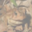

In [88]:
decode_img(img)

In [89]:
output=vae(adjust(torch.Tensor(img)[None, :]).to(device))[0]

In [91]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
